## Setting up

### Loading modules

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from astroquery.ipac.ned import Ned
# from astroquery.vizier import Vizier
# from astroquery.sdss import SDSS
import astropy.coordinates as coords
import astropy.units as u
from astropy.io import fits, ascii
from astropy.wcs import WCS
# from astropy.table import Table, QTable
from astropy.nddata import Cutout2D
import matplotlib as mpl
import matplotlib.pyplot as plt
import re, os, warnings
from astropy.utils.exceptions import AstropyWarning
import astropy.visualization as viz
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
from spectral_cube import SpectralCube
from scipy.stats import ks_2samp
# import legacystamps
# import splusdata
import yaml
from regions import Regions
import arviz as az

os.chdir('/mnt/scratch/HCGs')
import hidefutils as utils
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='converting a masked element to nan ')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "axes.linewidth": 1.5
})

### Define directory paths for output figures & tables

In [2]:
figdir = './hidef_figures/'
mapdir = './maps_figures/'

## Deriving the `MHI-Lr` scaling relation

### Perform MCMC fit of MHI-Lr for AMIGA galaxies

In [66]:
arrays_split, trace_split = utils.fit_lum_mass(split_morph=True)
arrays_whole, trace_whole = utils.fit_lum_mass(split_morph=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


### Plot the fit relations

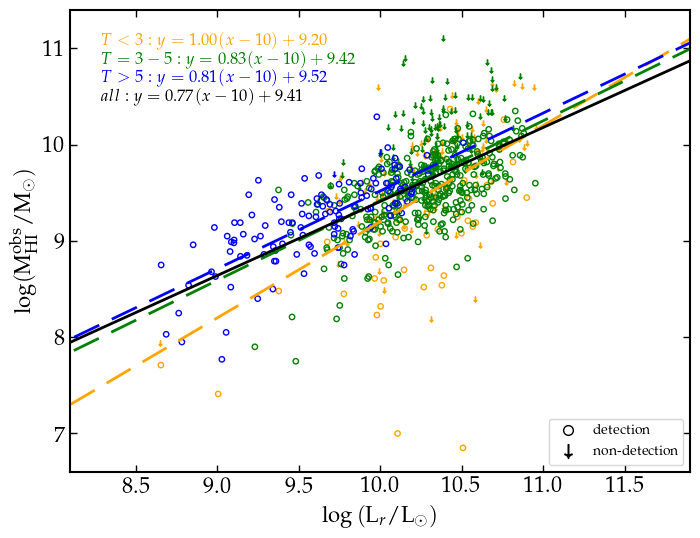

In [67]:
utils.plot_fit(arrays_split, trace_split, trace_whole)

### LaTeX table: AMIGA MHI fit results

In [68]:
header = '\\begin{table}\n\
\centering\n\
\\caption{Linear regression fit results of \Cref{eq:mpred}}\
\\label{tab:mcmc_fit}\n\
\\addtolength{\\tabcolsep}{-2pt}\n\
\\begin{tabular}{c c c c c c} \n\
\\hline \n\
\\hline \n\
\\rule{0pt}{10pt}\n\
Type & Det. & Non-det. & $\\alpha^T$ & $\\beta^T$ & $\sigma^T$ \\\\ \n\
\\hline \\rule{0pt}{10pt}\n'

T_text = ['${<}3$', '$3{-}5$', '${>}5$']

fout = open('/mnt/scratch/HCGs/tables/mcmc_fit.tex', 'w')
fout.write(header)

for i, (x, t) in enumerate(zip(arrays_split, trace_split)):
    n_det, n_und = len(x[0]), len(x[1])
    slope, intercept, sigma = az.summary(t, var_names=['slope', 'intercept', 'sigma'], round_to=2)['mean'].values
    e_slope, e_intercept, e_sigma = az.summary(t, var_names=['slope', 'intercept', 'sigma'], round_to=2)['sd'].values
    
    line = f'{T_text[i]} & {n_det} & {n_und} & ${slope:.2f}\\pm{e_slope:.2f}$ & ${intercept:.2f}\\pm{e_intercept:.2f}$ & ${sigma:.2f}\\pm{e_sigma:.2f}$ \\\\ \n'
    fout.write(line)
n_det_all, n_und_all = len(arrays_whole[0]), len(arrays_whole[1])
slope_all, intercept_all, sigma_all = az.summary(trace_whole, var_names=['slope', 'intercept', 'sigma'], round_to=2)['mean'].values
e_slope_all, e_intercept_all, e_sigma_all = az.summary(trace_whole, var_names=['slope', 'intercept', 'sigma'], round_to=2)['sd'].values
fout.write(f'all & {n_det_all} & {n_und_all} & ${slope_all:.2f}\\pm{e_slope_all:.2f}$ & ${intercept_all:.2f}\\pm{e_intercept_all:.2f}$ & ${sigma_all:.2f}\\pm{e_sigma_all:.2f}$ \\\\ \n')
fout.write('\\hline\n')
fout.write('\\end{tabular}\n\
\\end{table}')
fout.close()

### MCMC fit: plot posterior distributions

/tmp/ipykernel_3087875/3987041897.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


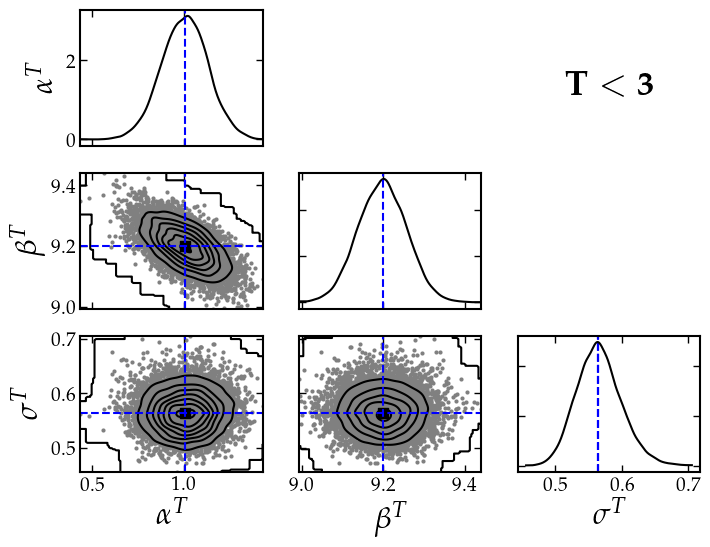

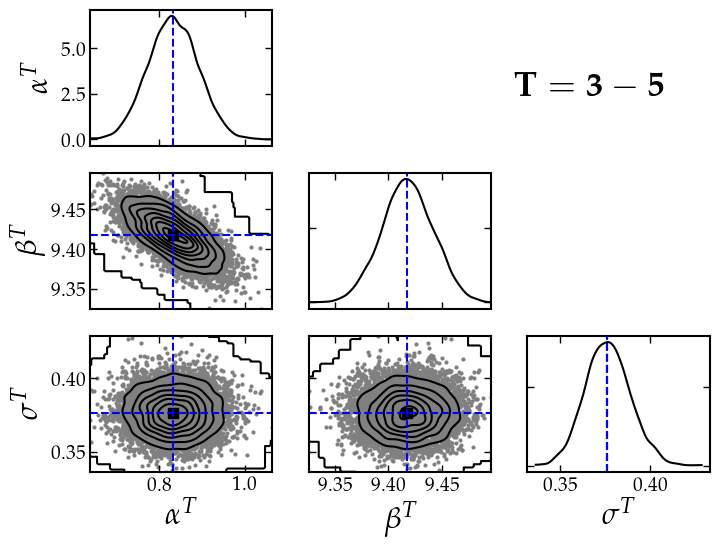

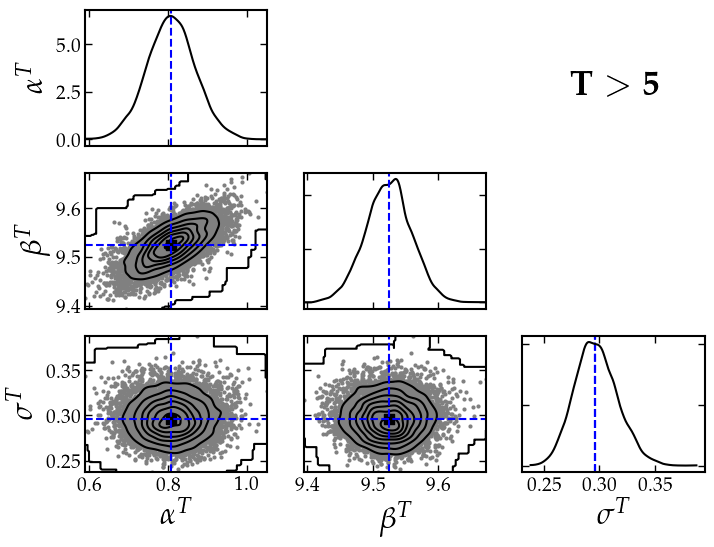

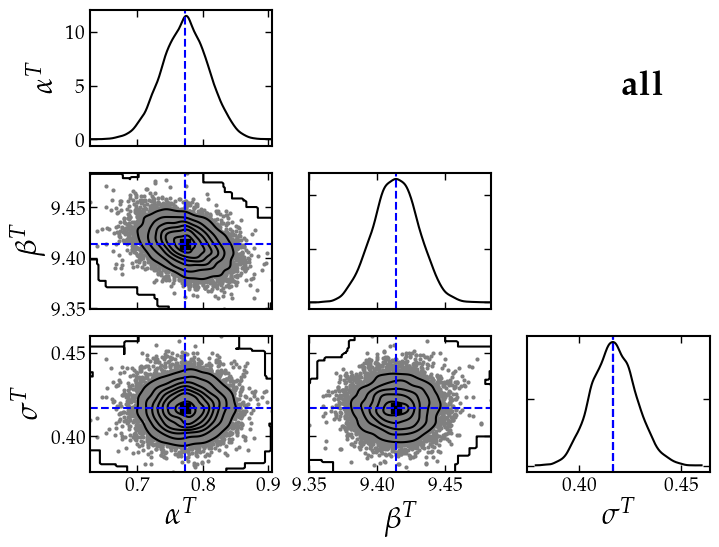

In [262]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
labels = [r'$\alpha^T$', r'$\beta^T$', r'$\sigma^T$']
trace_id = ['early', 'interm', 'late']
T_text = ['T<3', 'T=3-5', 'T>5', 'all']

for i_trace in range(4):
    if i_trace < 3:
        trace = trace_split[i_trace]
        t_class = trace_id[i_trace]
    else:
        trace = trace_whole
        t_class = 'whole'
    f = az.plot_pair(trace,
                    var_names=['slope', 'intercept', 'sigma'],
                    kind=['scatter', 'kde'],
                    marginals=True,
                    point_estimate='median',
                    point_estimate_kwargs={'ls': '--', 'lw': '1.5', 'color': 'b'},
                    marginal_kwargs={'kind': 'kde', 'color': 'k'},
                    scatter_kwargs={'color': 'gray'},
                    figsize=(8,6))

    for i in range(3):
        f[i,0].set_ylabel(labels[i], size=22)
        f[2,i].set_xlabel(labels[i], size=22)
    for i in range(3):
        for j in range(3): 
            # f[i,j].xaxis.set_minor_locator(AutoMinorLocator())
            # f[i,j].yaxis.set_minor_locator(AutoMinorLocator())
            try:
                f[i,j].tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
                f[i,j].tick_params(axis='both', which='minor', direction='in', right=True, top=True, length=2, width=1)
            except AttributeError:
                pass
    plt.text(0.75, 2.95, f'$\\bf {T_text[i_trace]}$', transform=plt.gca().transAxes,
         ha='right', va='top',
         fontsize=25, color='black', weight='bold')
    plt.tight_layout()
    plt.savefig(figdir+f'posterior_dist_{t_class}.pdf', dpi=100)

## HI deficiencies of HCGs

### Compute HI deficiency and associated parameters for HCGs

In [227]:
import importlib
import hidefutils
importlib.reload(hidefutils)
import hidefutils as utils

In [228]:
figdir = './hidef_figures/'
mapdir = './maps_figures/'

In [229]:
group_list = ['HCG 16', 'HCG 30', 'HCG 31', 'HCG 90', 'HCG 91', 'HCG 97']
for g in group_list:
    x, _ = utils.hcg_hi_content(g, plot=False)
# x, _ = utils.hcg_hi_content('HCG 90', plot=False)

/mnt/scratch/HCGs/hidefutils.py:1725: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)
/mnt/scratch/HCGs/hidefutils.py:1726: RuntimeWarning: All-NaN slice encountered
  pb_median = np.nanmedian(np.squeeze(pb_data), axis=0)
/mnt/scratch/HCGs/hidefutils.py:1725: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)
/mnt/scratch/HCGs/hidefutils.py:1726: RuntimeWarning: All-NaN slice encountered
  pb_median = np.nanmedian(np.squeeze(pb_data), axis=0)
/opt/conda/envs/hidef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/opt/conda/envs/hidef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/opt/conda/envs/hidef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py

HCG 91 -- HCG 91D: no moment map found, assuming a non-detection


/mnt/scratch/HCGs/hidefutils.py:1725: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)
/mnt/scratch/HCGs/hidefutils.py:1726: RuntimeWarning: All-NaN slice encountered
  pb_median = np.nanmedian(np.squeeze(pb_data), axis=0)


### Plot relations of MHI and defHI

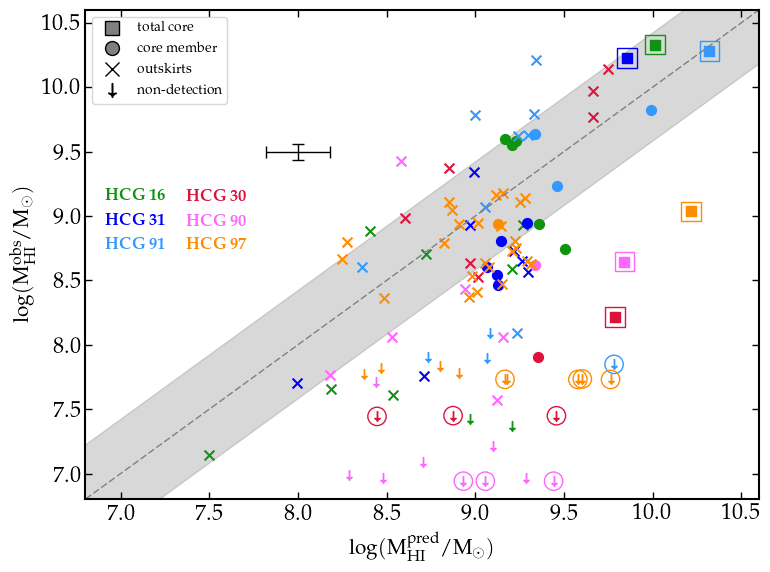

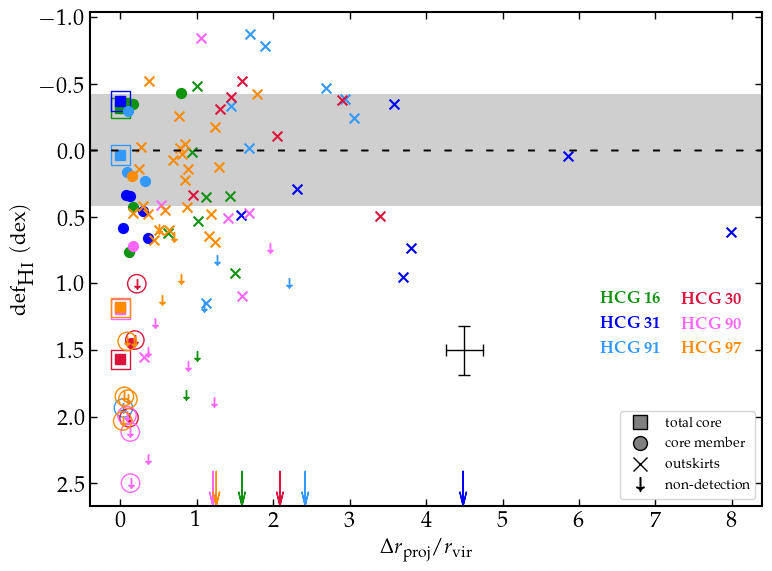

In [230]:
group_list = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']

### Plot MHI vs Ms
utils.plot_defhi(group_list, par='mass', savefig=True)

### Plot HI-def vs dist
utils.plot_defhi(group_list, par='hidef', savefig=True)

## Optical – HI relations

### Plot of MHI-Mstar

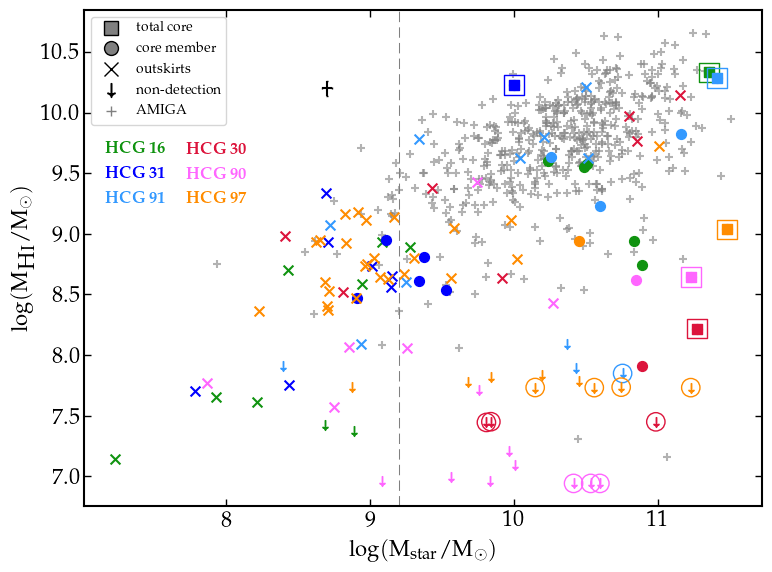

In [231]:
utils.plot_hi_star(group_list, savefig=True)

### Plot of _g-r_ colour (not included in paper)

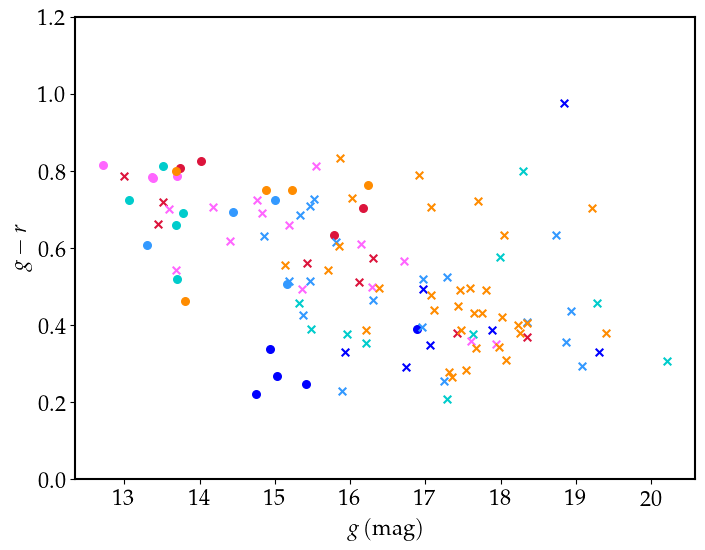

In [53]:
markers = {'HCG 16': ['o','#00CCCC'],
            'HCG 30': ['x','#DC143C'],
            'HCG 31': ['o','#0000FF'],
            'HCG 90': ['x','#FF66FF'],
            'HCG 91': ['o','#3399FF'],
            'HCG 97': ['x','#FF8C00']
            }
fig, ax = plt.subplots(figsize=(8,6))
for hcgno in [16, 30, 31, 90, 91, 97]:
    marker = markers[f'HCG {hcgno}']
    df = pd.read_csv(f'params_tables/HIdef_hcg{hcgno}.csv')
    df.dropna(subset=['Name'], inplace=True)
    df = df[df.Name.str.replace(' ', '') != 'core:total']
    m_core = df.Name.str.contains('core')
    df_core, df_nocore = df[m_core], df[~m_core]

    ax.scatter(df_nocore.gmag, df_nocore.gmag-df_nocore.rmag, marker='x', c=marker[1], s=30)
    ax.scatter(df_core.gmag, df_core.gmag-df_core.rmag, marker='o', c=marker[1], s=30)
    # for i,row in df_core.iterrows():
    #     name = row.Name.replace('core: ','').replace('HCG ','')
    #     ax.text(row.logMs, row.logMHIobs, name, fontsize=8)
    ax.set_xlabel(r'$ g\, \rm(mag)$')
    ax.set_ylabel(r'$g-r$')
ax.set_ylim(0,1.2);
plt.savefig('gr_cmd.png')

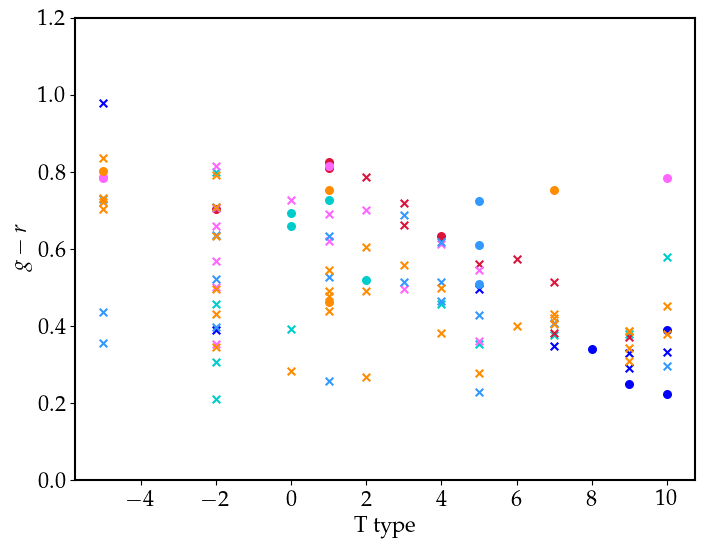

In [157]:
fig, ax = plt.subplots(figsize=(8,6))
for hcgno in [16, 30, 31, 90, 91, 97]:
    marker = markers[f'HCG {hcgno}']
    df = pd.read_csv(f'params_tables/HIdef_hcg{hcgno}.csv')
    df.dropna(subset=['Name'], inplace=True)
    df = df[df.Name.str.replace(' ', '') != 'core:total']
    m_core = df.Name.str.contains('core')
    df_core, df_nocore = df[m_core], df[~m_core]

    ax.scatter(df_nocore.T_type, df_nocore.gmag-df_nocore.rmag, marker='x', c=marker[1], s=30)
    ax.scatter(df_core.T_type, df_core.gmag-df_core.rmag, marker='o', c=marker[1], s=30)
    # for i,row in df_core.iterrows():
    #     name = row.Name.replace('core: ','').replace('HCG ','')
    #     ax.text(row.logMs, row.logMHIobs, name, fontsize=8)
    ax.set_xlabel(r'T type')
    ax.set_ylabel(r'$g-r$')
ax.set_ylim(0,1.2);

## Distributions of Mstar, MHI and defHI

### Mstar distribution

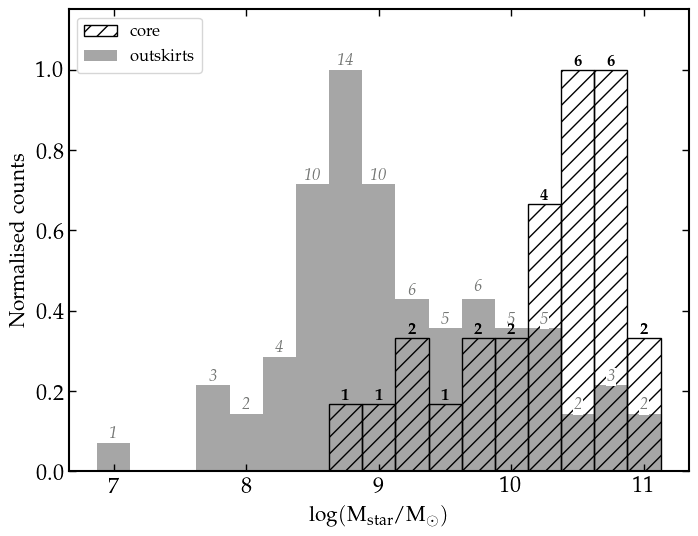

In [232]:
markers = {'HCG 16': ['o','#00CCCC'],
            'HCG 30': ['x','#DC143C'],
            'HCG 31': ['o','#0000FF'],
            'HCG 90': ['x','#FF66FF'],
            'HCG 91': ['o','#3399FF'],
            'HCG 97': ['x','#FF8C00']
            }

# Compute the histograms and normalize them
def make_hist(data:np.ndarray, lims:list=[7,11.5], step=0.25, norm=True):
    counts, bin_edges = np.histogram(data, bins=np.arange(lims[0],lims[1],step))
    if norm:
        counts = counts / counts.max()
    return counts, bin_edges

def show_bin_counts(bars, nums, color='k', size=12, bold=False, opaque=[], shift=[], shift_val=0.01, ax=None):
    if bold:
        wgt = r'\bf'
    else:
        wgt = r'\it'
    for i, (bar, num) in enumerate(zip(bars, nums)):
        if num > 0:
            if i in shift:
                yshift = shift_val
            else:
                yshift = 0.
            if i in opaque:
                bbox_props = dict(facecolor='w', edgecolor='None', alpha=1, pad=0.5)
            else:
                bbox_props = None
            txt = ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position of the label
                bar.get_height() + yshift,  # Y position of the label
                r'$%s{%s}$' %(wgt,num),
                color=color,
                size=size,
                ha='center', va='bottom',
                bbox = bbox_props,
                zorder=50)
        
df_cores, df_nocores = pd.DataFrame(), pd.DataFrame()
for hcgno in [16, 30, 31, 90, 91, 97]:
    marker = markers[f'HCG {hcgno}']
    df = pd.read_csv(f'/mnt/scratch/HCGs/params_tables/HIdef_hcg{hcgno}.csv')
    df.dropna(subset=['Name'], inplace=True)
    df = df[df.Name.str.replace(' ', '') != 'core:total']
    m_core = df.Name.str.contains('core')
    df_core, df_nocore = df[m_core], df[~m_core]
    df_cores = pd.concat([df_cores, df_core])
    df_nocores = pd.concat([df_nocores, df_nocore])

step = 0.25
c_counts, c_bin_edges = make_hist(df_cores.logMs.values, step=step)
o_counts, o_bin_edges = make_hist(df_nocores.logMs.values, step=step)

c_counts_num, _ = make_hist(df_cores.logMs.values, step=step, norm=False)
o_counts_num, _ = make_hist(df_nocores.logMs.values, step=step, norm=False)

fig, ax = plt.subplots(figsize=(8,6))
cbars = ax.bar(c_bin_edges[:-1], c_counts, width=c_bin_edges[1]-c_bin_edges[0], ec='k',
       fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)

obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       alpha=0.7, label='outskirts', zorder=1);

show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
show_bin_counts(obars, o_counts_num, color='#777977', shift=[11], opaque=[13,14,15,16], ax=ax)

ax.set_ylim(ymax=1.15)
ax.set_xlabel(r'$\rm \log(M_{star}/M_\odot)$', size=15)
ax.set_ylabel('Normalised counts', size=15);
ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
ax.legend(loc='upper left', fontsize=12, frameon=True);
plt.savefig(figdir+'hist_mstar.pdf')

### MHI distribution (not included in paper)

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


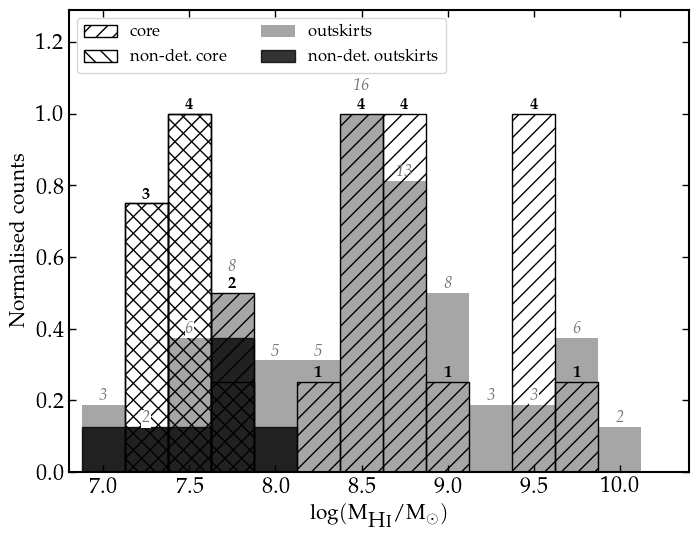

In [233]:
step = 0.25

def return_counts(cdf, odf, column, step, limits):
       c_counts, c_bin_edges = make_hist(cdf[column].values, lims=limits, step=step)
       o_counts, o_bin_edges = make_hist(odf[column].values, lims=limits, step=step)

       # cl_counts, cl_bin_edges = make_hist(cdf[cdf.MHIlim_flag == 1][column].values, lims=limits, step=step)
       # ol_counts, ol_bin_edges = make_hist(odf[odf.MHIlim_flag == 1][column].values, lims=limits, step=step)

       c_counts_num, _ = make_hist(cdf[column].values, norm=False, lims=limits, step=step)
       cl_counts_num, _ = make_hist(cdf[cdf.MHIlim_flag == 1][column].values, norm=False, lims=limits, step=step)

       o_counts_num, _ = make_hist(odf[column].values, norm=False, lims=limits, step=step)
       ol_counts_num, _ = make_hist(odf[odf.MHIlim_flag == 1][column].values, norm=False, lims=limits, step=step)

       cl_counts_norm = c_counts * cl_counts_num/c_counts_num
       ol_counts_norm = o_counts * ol_counts_num/o_counts_num

       return c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num

c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores, df_nocores, 'logMHIobs', step, [7,11.5])

fig, ax = plt.subplots(figsize=(8,6))
cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
       fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)

ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
       hatch='\\\\', alpha=1, label='non-det. core', zorder=4);

obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       alpha=0.7, label='outskirts', zorder=1);
ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
       alpha=0.8, label='non-det. outskirts', zorder=4);

show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
show_bin_counts(obars, o_counts_num, color='#777977', shift=[3,6], shift_val=0.05, opaque=[1,2,10], ax=ax)

ax.set_xlabel(r'$\rm \log(M_\textsc{Hi}/M_\odot)$', size=15)
ax.set_ylabel('Normalised counts', size=15);
ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
ax.legend(ncol=2, loc='upper left', fontsize=12, frameon=True);
ax.set_xlim(6.8,10.4); ax.set_ylim(ymax=1.29)
plt.savefig(figdir+'hist_himass.pdf')

### HI-def distribution

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


core: 0.72+/-0.03, outskirts: 0.45+/-0.01


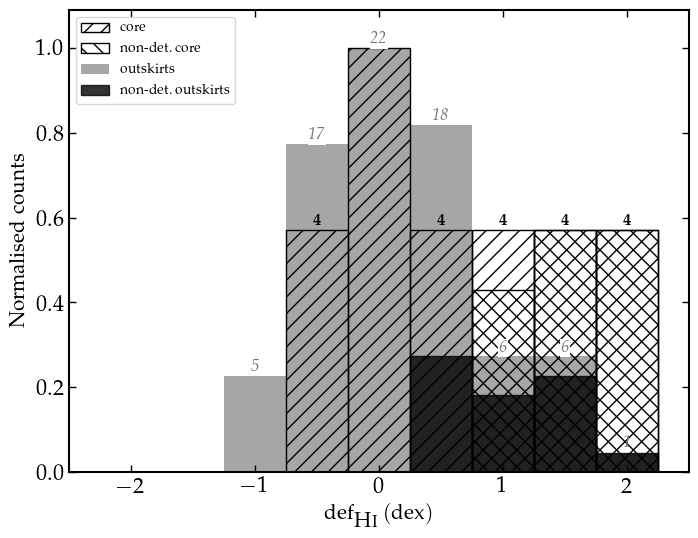

In [234]:
deflims, step = [-3,3], 0.5
c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores, df_nocores, 'defHI', step, deflims)

fig, ax = plt.subplots(figsize=(8,6))
cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
       fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)
ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
       hatch='\\\\', alpha=1, label='non-det. core', zorder=4);
obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       alpha=0.7, label='outskirts', zorder=1);
ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
       alpha=0.8, label='non-det. outskirts', zorder=4);

show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
show_bin_counts(obars, o_counts_num, color='#777977', opaque=[5,6,8,9], ax=ax)

print('core: %.2f+/-%.2f, outskirts: %.2f+/-%.2f' 
       %(np.nanmedian(df_cores.defHI.values),np.nanstd(df_cores.defHI.values)/len(df_cores.defHI.values), np.nanmedian(df_nocores.defHI.values), np.nanstd(df_nocores.defHI.values)/len(df_nocores.defHI.values)))

ax.set_xlim(-2.5,2.5)
ax.set_ylim(ymax=1.09)
ax.set_xlabel(r'$\rm def_\textsc{Hi}\,(dex)$', size=15)
ax.set_ylabel('Normalised counts', size=15);
ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
ax.set_xticks(np.arange(-2,3))
ax.legend(loc='upper left', fontsize=10, frameon=True);
plt.savefig(figdir+'hist_hidef.pdf')

### HI-def distribution: comparison of core and outskirts and different phases

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 2
   core: 0.34+/-0.16, outskirts: 0.35+/-0.20
ks = 0.37, p = 0.10074


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 3
   core: 1.85+/-0.25, outskirts: 0.46+/-0.08
ks = 0.65, p = 0.00012


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num
/tmp/ipykernel_3387139/1480042893.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels)


Phase: 0
   core: 0.72+/-0.35, outskirts: 0.45+/-0.08
ks = 0.20, p = 0.35811


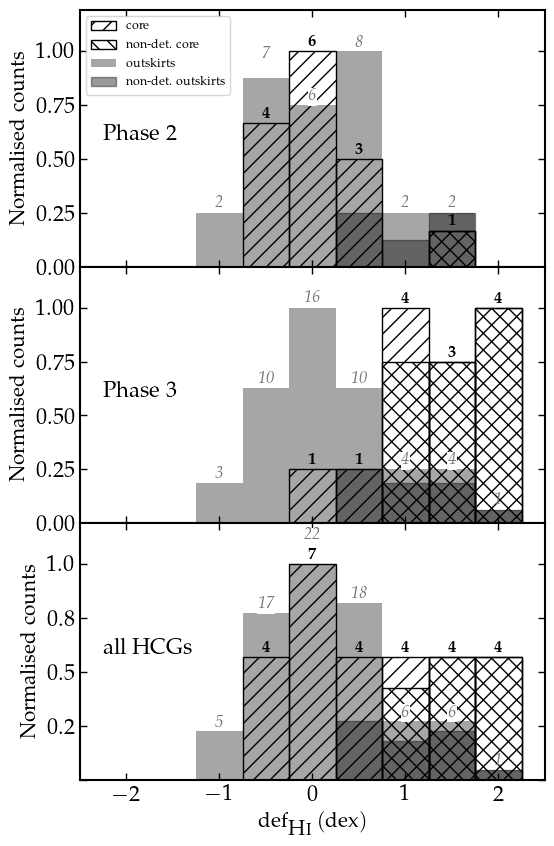

In [235]:
def hist_std(x, n_samples=1000):

       # Generate bootstrap samples and calculate the median for each sample
       bootstrap_medians = [
       x.sample(frac=1, replace=True).median() for _ in range(n_samples)
       ]
       # Calculate the standard deviation of the bootstrap medians, which is the error on the median
       median_error = np.std(bootstrap_medians)
       return median_error


def make_hist_axes(n, ax):
       if n in [2,3]:
              gp = {2: [16,31,91], 3: [30,90,97]}
              p = gp[n]
              df_cores_p = df_cores[df_cores.HCG.isin(p)]
              df_nocores_p = df_nocores[df_nocores.HCG.isin(p)]
       else:
              df_cores_p, df_nocores_p = df_cores, df_nocores
              
       deflims, step = [-3,3], 0.5
       
       c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores_p, df_nocores_p, 'defHI', step, deflims)
       
       cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
              fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)
       ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
              hatch='\\\\', alpha=1, label='non-det. core', zorder=4);
       obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
              alpha=0.7, label='outskirts', zorder=1);
       ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
              alpha=0.4, label='non-det. outskirts', zorder=4);
       ax.set_ylabel('Normalised counts', size=15);
       ax.set_xlim(-2.5,2.5)
       if n == 2:
              ax.legend(loc='upper left', fontsize=9, frameon=True);
              shift, shift_val = [5], 0.07
              opaque = [6]
       elif n == 3:
              shift, shift_val = [], 0.01
              opaque = [8,9]
       else:
              ax.set_xlabel(r'$\rm def_\textsc{Hi}\,(dex)$', size=15)
              yticks = ax.get_yticks()
              ytick_labels = ["" if tick == 0 else '%.1f' %tick for tick in yticks]
              ax.set_yticklabels(ytick_labels)
              shift, shift_val = [6], 0.09
              opaque=[5,6,8,9]

       show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
       show_bin_counts(obars, o_counts_num, color='#777977', shift=shift, shift_val=shift_val, opaque=opaque, ax=ax)
       
       if n in [2,3]:
              txt = f'Phase {n}'
       else:
              txt = 'all HCGs'
       ax.set_ylim(ymax=1.19)
       ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
       ax.text(0.05, 0.55, txt, ha='left', va='top', transform=ax.transAxes)
       ax.set_xticks(np.arange(-2,3))
       
       print('Phase: %d\n   core: %.2f+/-%.2f, outskirts: %.2f+/-%.2f' 
             %(n,np.nanmedian(df_cores_p.defHI.values), hist_std(df_cores_p.defHI), np.nanmedian(df_nocores_p.defHI.values), hist_std(df_nocores_p.defHI)))
       ks_stat, p_val = ks_2samp(df_cores_p.defHI.values, df_nocores_p.defHI.values)
       print(f'ks = {ks_stat:.2f}, p = {p_val:.5f}')

fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(3,1, height_ratios=[1,1,1], hspace=0)
axt = fig.add_subplot(gs[0])
axm = fig.add_subplot(gs[1], sharex=axt)
axb = fig.add_subplot(gs[2], sharex=axt)

for n, ax in zip([2,3,0], [axt,axm,axb]):
       make_hist_axes(n, ax)
plt.setp(axt.get_xticklabels(), visible=False);
plt.savefig(figdir+'hist_hidef_phases_all.pdf')

### Review plot: Stellar mass distribution

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 2
   core: 10.37+/-0.33, outskirts: 8.95+/-0.15
ks = 0.45, p = 0.02671


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 3
   core: 10.56+/-0.13, outskirts: 9.24+/-0.19
ks = 0.69, p = 0.00004


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num
/tmp/ipykernel_3387139/1132235995.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels)


Phase: 0
   core: 10.51+/-0.11, outskirts: 9.11+/-0.10
ks = 0.49, p = 0.00004


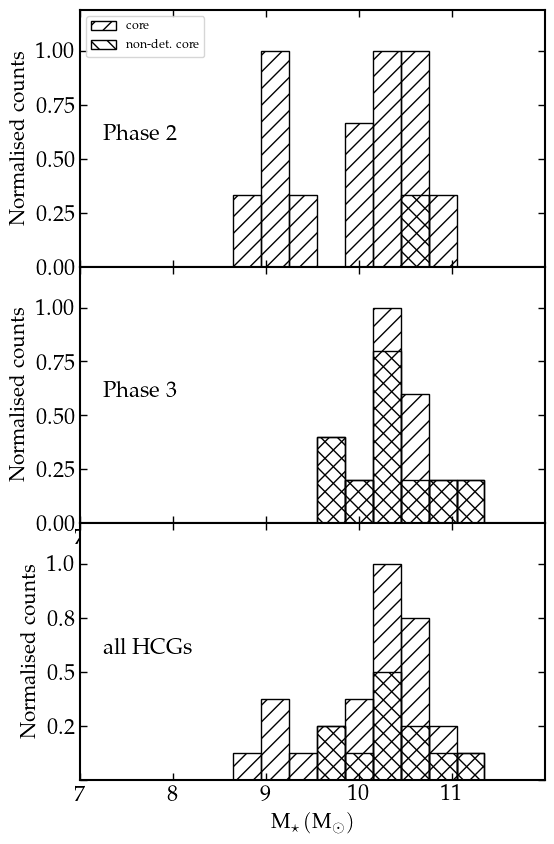

In [236]:
def hist_std(x, n_samples=1000):

       # Generate bootstrap samples and calculate the median for each sample
       bootstrap_medians = [
       x.sample(frac=1, replace=True).median() for _ in range(n_samples)
       ]
       # Calculate the standard deviation of the bootstrap medians, which is the error on the median
       median_error = np.std(bootstrap_medians)
       return median_error


def make_hist_axes(n, ax):
       if n in [2,3]:
              gp = {2: [16,31,91], 3: [30,90,97]}
              p = gp[n]
              df_cores_p = df_cores[df_cores.HCG.isin(p)]
              df_nocores_p = df_nocores[df_nocores.HCG.isin(p)]
       else:
              df_cores_p, df_nocores_p = df_cores, df_nocores
              
       mslims, step = [7,12], 0.3
       
       c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores_p, df_nocores_p, 'logMs', step, mslims)
       
       cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
              fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)
       ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
              hatch='\\\\', alpha=1, label='non-det. core', zorder=4);
       # obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       #        alpha=0.7, label='outskirts', zorder=1);
       # ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
       #        alpha=0.4, label='non-det. outskirts', zorder=4);
       ax.set_ylabel('Normalised counts', size=15);
       ax.set_xlim(7,12)
       if n == 2:
              ax.legend(loc='upper left', fontsize=9, frameon=True);
              shift, shift_val = [5], 0.07
              opaque = [6]
       elif n == 3:
              shift, shift_val = [], 0.01
              opaque = [8,9]
       else:
              ax.set_xlabel(r'$\rm M_\star\,(M_\odot)$', size=15)
              yticks = ax.get_yticks()
              ytick_labels = ["" if tick == 0 else '%.1f' %tick for tick in yticks]
              ax.set_yticklabels(ytick_labels)
              shift, shift_val = [], 0.01
              opaque=[5,6,8,9]

       # show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
       # show_bin_counts(obars, o_counts_num, color='#777977', shift=shift, shift_val=shift_val, opaque=opaque, ax=ax)
       
       if n in [2,3]:
              txt = f'Phase {n}'
       else:
              txt = 'all HCGs'
       ax.set_ylim(ymax=1.19)
       ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
       ax.text(0.05, 0.55, txt, ha='left', va='top', transform=ax.transAxes)
       ax.set_xticks(np.arange(7,12))
       
       print('Phase: %d\n   core: %.2f+/-%.2f, outskirts: %.2f+/-%.2f' 
             %(n,np.nanmedian(df_cores_p.logMs.values), hist_std(df_cores_p.logMs), np.nanmedian(df_nocores_p.logMs.values), hist_std(df_nocores_p.logMs)))
       ks_stat, p_val = ks_2samp(df_cores_p.logMs.values, df_nocores_p.logMs.values)
       print(f'ks = {ks_stat:.2f}, p = {p_val:.5f}')

fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(3,1, height_ratios=[1,1,1], hspace=0)
axt = fig.add_subplot(gs[0])
axm = fig.add_subplot(gs[1], sharex=axt)
axb = fig.add_subplot(gs[2], sharex=axt)

for n, ax in zip([2,3,0], [axt,axm,axb]):
       make_hist_axes(n, ax)
plt.setp(axt.get_xticklabels(), visible=False);
plt.savefig(figdir+'hist_mstar_phases_all.png')

### MHI and HI-def: comparison of MeerKAT and VLA

/tmp/ipykernel_3387139/2473982651.py:71: RuntimeWarning: invalid value encountered in divide
  mc_norm = mc * num_30b/mc_num


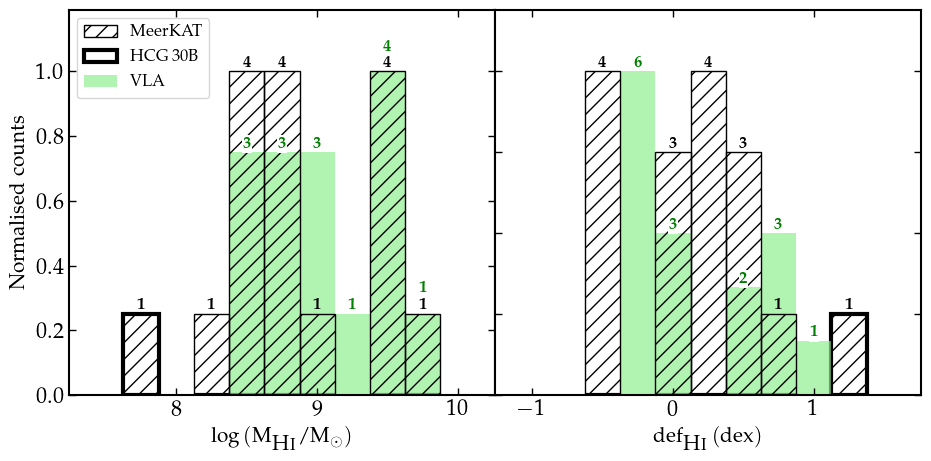

In [237]:
vla_tab = ascii.read('HCG_HI_tables/HCG_mems_VLA_HI.ascii',
                        comment='#')
m_ = np.isin(vla_tab['HCG'], [16,30,31,90,91,97])
vla_tab_sub = vla_tab[m_]
vla_tab_sub = vla_tab_sub[~np.isnan(vla_tab_sub['logMHI'])]
vla_mhi = np.array(vla_tab['logMHI'])
vla_mhi_sub = np.array(vla_tab_sub['logMHI'])
vla_def_sub = np.array(vla_tab_sub['HIdef'])
df_cores_all, df_nocores = pd.DataFrame(), pd.DataFrame()
for hcgno in [16, 30, 31, 90, 91, 97]:
    marker = markers[f'HCG {hcgno}']
    df = pd.read_csv(f'params_tables/HIdef_hcg{hcgno}.csv')
    df.dropna(subset=['Name'], inplace=True)
#     df = df[df.MHIlim_flag == 0] ### exclude non-detections
    df = df[df.Name.str.replace(' ', '') != 'core:total']
    m_core = df.Name.str.contains('core')
    df_core, df_nocore = df[m_core], df[~m_core]
    df_cores_all = pd.concat([df_cores_all, df_core])
    df_nocores = pd.concat([df_nocores, df_nocore])

step = 0.25
df_cores = df_cores_all[df_cores_all.MHIlim_flag==0]
df_30b   = df_cores[df_cores.Name.str.contains('30B')]

panel = 'double'

if panel == 'single':

       lims=[-1,2]
       mc, mc_bin_edges = make_hist(df_cores.defHI.values, step=step, lims=lims)
       mc_num, _ = make_hist(df_cores.defHI.values, step=step, lims=lims, norm=False)
       num_30b, _ = make_hist(df_30b.defHI.values, step=step, lims=lims, norm=False)
       mc_norm = mc * num_30b/mc_num

       vs_counts, vs_bin_edges = make_hist(vla_def_sub, step=step, lims=lims)
       vs_num, _ = make_hist(vla_def_sub, step=step, lims=lims, norm=False)

       fig, ax = plt.subplots(figsize=(8,6))
       mbars = ax.bar(mc_bin_edges[:-1], mc, width=step, ec='k',
              fc='None', lw=1, alpha=1, hatch='//', label='MeerKAT', zorder=2)
       ax.bar(mc_bin_edges[:-1], mc_norm, width=step, ec='k', fc='None', lw=3,
              alpha=1, label='HCG 30B', zorder=1);

       vbars = ax.bar(vs_bin_edges[:-1], vs_counts, width=step, color='lightgreen',
              alpha=0.7, label='VLA', zorder=1);

       show_bin_counts(mbars, mc_num, bold=True)
       show_bin_counts(vbars, vs_num, bold=True, color='green', shift=[], shift_val=0.1, opaque=[4,6,8])

       ax.set_xlabel(r'$\rm def_{\textsc{Hi}}\,(dex)$', size=15)
       ax.set_ylabel('Normalised counts', size=15);
       ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
       ax.legend(loc='upper right', fontsize=12, frameon=True);
       plt.ylim(ymax=1.09); plt.xlim(xmin=-0.8,xmax=1.49);
       # plt.savefig(figdir+'hist_def_mkt_vla.pdf')

elif panel == 'double':
       fig = plt.figure(figsize=(11,5))
       gs = fig.add_gridspec(1,2, width_ratios=[1,1], wspace=0)
       axl = fig.add_subplot(gs[0])
       axr = fig.add_subplot(gs[1], sharey=ax)
       axs = [axl, axr]
       lims = [[7.5,10.5], [-1,2]]
       cols = ['logMHIobs','defHI']
       xlabels = [r'$\rm \log{(M_{\textsc{Hi}}/M_\odot)}$', r'$\rm def_{\textsc{Hi}}\,(dex)$']
       vla_data = [vla_mhi_sub, vla_def_sub]
       for i in range(2):
              mc, mc_bin_edges = make_hist(df_cores[cols[i]].values, step=step, lims=lims[i])
              mc_num, _ = make_hist(df_cores[cols[i]].values, step=step, lims=lims[i], norm=False)
              num_30b, _ = make_hist(df_30b[cols[i]].values, step=step, lims=lims[i], norm=False)
              mc_norm = mc * num_30b/mc_num

              vc, v_bin_edges = make_hist(vla_data[i], step=step, lims=lims[i])
              vc_num, _ = make_hist(vla_data[i], step=step, lims=lims[i], norm=False)

              mbars = axs[i].bar(mc_bin_edges[:-1], mc, width=step, ec='k',
                     fc='None', lw=1, alpha=1, hatch='//', label='MeerKAT', zorder=2)
              axs[i].bar(mc_bin_edges[:-1], mc_norm, width=step, ec='k', fc='None', lw=3,
                     alpha=1, label='HCG 30B', zorder=1);

              vbars = axs[i].bar(v_bin_edges[:-1], vc, width=step, color='lightgreen',
                     alpha=0.7, label='VLA', zorder=1);

              axs[i].set_xlabel(xlabels[i], size=15)
              if i == 0:
                     axs[i].set_ylabel('Normalised counts', size=15)
                     axs[i].legend(loc='upper left', fontsize=12, frameon=True);
                     shift = [8,9]
                     opaque = [4,5]
              else:
                     shift = []
                     opaque = [4,6,8]
              show_bin_counts(mbars, mc_num, bold=True, ax=axs[i])
              show_bin_counts(vbars, vc_num, bold=True, color='green', ax=axs[i], shift=shift, shift_val=0.05, opaque=opaque)
              axs[i].tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
              axs[i].set_ylim(ymax=1.19);
       plt.setp(axs[1].get_yticklabels(), visible=False);
       plt.savefig(figdir+'hist_mhi_def_mkt_vla.pdf')

### LaTeX table + plots: HCGs cores in panels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


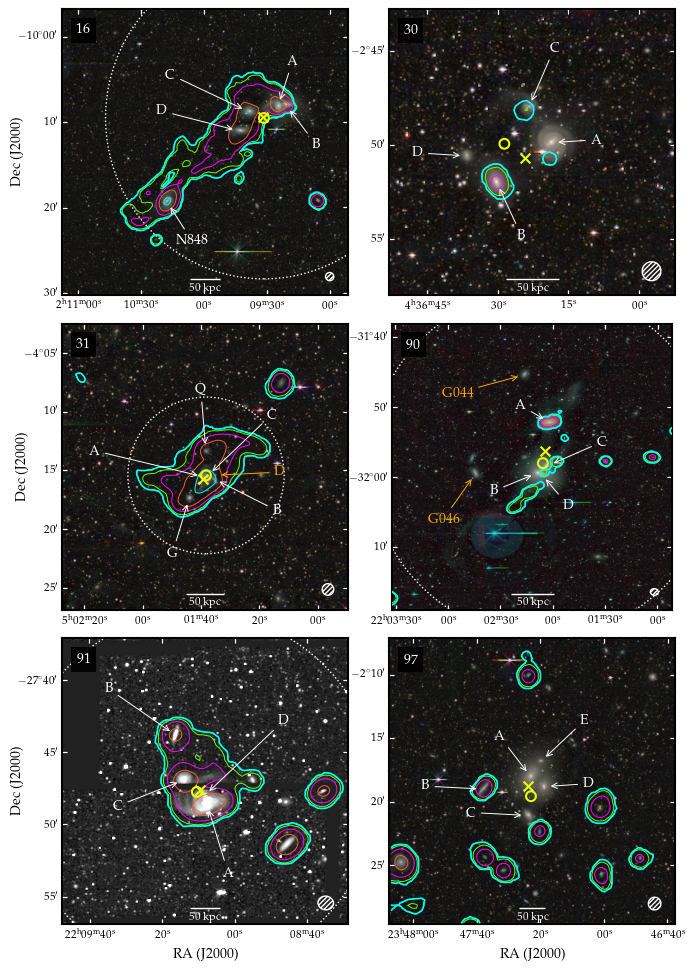

In [238]:
with open('/mnt/scratch/HCGs/group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('/mnt/scratch/HCGs/data_files.yml') as f:
    params = yaml.safe_load(f)

def inflate_array(array, axis, factor):
    npix_axis = array.shape[axis]
    npix_other_axis = array.shape[1-axis]
    npix_add = int((1.-factor) * npix_axis)
    if axis == 0:
        # npix_axis = array.shape[0]
        # npix_other_axis = array.shape[1]
        new_dims = (npix_axis+npix_add, npix_other_axis)
        inflated_array = np.full(new_dims, np.nan)
        inflated_array[int(0.5*npix_add):npix_axis+int(0.5*npix_add), :] = array
    elif axis == 1:
        new_dims = (npix_other_axis, npix_axis+npix_add)
        inflated_array = np.full(new_dims, np.nan)
        inflated_array[:, int(0.5*npix_add):npix_axis+int(0.5*npix_add)] = array
    return inflated_array


fig = plt.figure(figsize=(8,10))

glist = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']
phase = {2: ['HCG 16', 'HCG 31', 'HCG 91'],
         3: ['HCG 30', 'HCG 90', 'HCG 97']}

grid = gridspec.GridSpec(3, 2)#, width_ratios=[1,1,1,0.07])

aspects = {'HCG 90': 0.85, 'HCG 91': 0.88}

nhi_3s_levels = {'HCG 16': 3.5,
                 'HCG 31': 3.3,
                 'HCG 91': 3.7,
                 'HCG 30': 3.3,
                 'HCG 90': 3.4,
                 'HCG 97': 3.2}

lsize=10
tsize=8

scale = u.Quantity(50.,unit='kpc')
scale_label = '50 kpc'

p_width = u.Quantity(250.,unit='kpc')

fontprops = FontProperties(size=8, family='monospace')
contour_color =  '#FF00FF'

header = '\\begin{table*}\n\
\centering\n\
\\caption{Comparison of the calculated centre of mass (CoM) coordinates of the HCGs with their quoted NED coordinates. \
The last column lists the separation between the two coordinates.}\
\\label{tab:com_coords}\n\
\\begin{tabular}{c c c c c c c} \n\
\\hline \n\
\\hline \n\
\\multirow{2}{*}{Phase} & \\multirow{2}{*}{HCG} & \\multicolumn{2}{c}{NED (J2000)} & \\multicolumn{2}{c}{CoM (J2000)} & $\\delta\\rm pos$ \\\\ \n\
 & & RA & Dec & RA & Dec & arcmin \\\\ \n'
fout = open('/mnt/scratch/HCGs/tables/centres_coords.tex', 'w')
fout.write(header)

hcg_boxes = {}

for i,g in enumerate(glist):
    
    levs = [nhi_3s_levels[g] * 1e18 * 2**(2*x) for x in range(10)]
    
    for k in phase.keys():
        if g in phase[k]: p = k
    grz, opthdr = fits.getdata('/mnt/scratch/HCGs/legacy_images/%s_grz.fits' %g.replace(' ',''), header=True)
    optwcs = WCS(opthdr).celestial
    try:
        pixsize = abs(opthdr['CDELT1'])
    except KeyError:
        pixsize = abs(opthdr['CD1_1'])
    
    dist = u.Quantity(params[g]['distance'], unit='Mpc')
    scale_angle = coords.Angle(float(scale.to('kpc') / dist.to('kpc')), unit='radian')
    scale_pix = scale_angle.degree / pixsize

    ned = Ned.query_object(g)
    gra, gdec = ned['RA'][0], ned['DEC'][0]
    members = group_members[g]
    fits_m0 = params[g]['rootdir'] + '/' + params[g]['moment_0']
    hidata, hihdr = fits.getdata(fits_m0, header=True)
    hiwcs = WCS(hihdr)

    bmaj, bmin, bpa = hihdr['BMAJ'], hihdr['BMIN'], hihdr['BPA']
    bmaj, bmin = coords.Angle(bmaj, unit='deg'), coords.Angle(bmin, unit='deg')
    if np.isnan(bpa): bpa = 0.0

    cm_ra, cm_dec = utils.center_of_mass(g)
    ned_ra, ned_dec = ned['RA'][0], ned['DEC'][0]
    ned_coo = coords.SkyCoord(ned_ra, ned_dec, unit='deg', frame='icrs')
    ned_ras, ned_decs = ned_coo.ra.to_string(unit=u.hourangle, sep=':', precision=2, pad=True), ned_coo.dec.to_string(sep=':', precision=2, pad=True)
    
    cm_coo = coords.SkyCoord(cm_ra, cm_dec, unit='deg', frame='icrs')
    cm_ras, cm_decs = cm_coo.ra.to_string(unit=u.hourangle, sep=':', precision=2, pad=True), cm_coo.dec.to_string(sep=':', precision=2, pad=True)
    
    sep = ned_coo.separation(cm_coo)
    if g in  ['HCG 16', 'HCG 30']:
        line = '\hline \\rule{0pt}{10pt} \n\\multirow{3}{*}{%d} & %s & %s & %s & %s & %s & %.2f\\\\ \n' %(p, g.split()[-1],ned_ras,ned_decs,cm_ras,cm_decs,sep.arcmin)
    else:
        line = ' & %s & %s & %s & %s & %s & %.2f\\\\ \n' %(g.split()[-1],ned_ras,ned_decs,cm_ras,cm_decs,sep.arcmin)

    ix, iy = i % 3, i // 3
    
    reg = Regions.read('box_regions/box_%s.reg' %g.replace(' ','').lower(), format='crtf')
    sub_coo = reg[0].center
    width, height = reg[0].width, reg[0].height
    try:
        width /= aspects[g]
    except KeyError:
        pass
    
    size = (width, height)
    hi_cutout = Cutout2D(hidata, sub_coo, size=max(size), wcs=hiwcs)
    if g == 'HCG 91':
        cutout = Cutout2D(grz[0], position=sub_coo, size=size, wcs=optwcs)
        rband = cutout.data
        aspect_ratio = rband.shape[1] / rband.shape[0]
        aspect_ratio = round(aspect_ratio, 2)

        ax = fig.add_subplot(grid[ix,iy], projection=cutout.wcs)
        cmap = mpl.colormaps.get_cmap('gray')
        cmap.set_bad('gray')
        ax.imshow(rband, origin='lower', cmap=cmap, norm=viz.ImageNormalize(rband, interval=viz.PercentileInterval(99.), stretch=viz.LogStretch(100)), aspect=aspects[g])
    else:
        stretch_func = 'asinh'
        contrast = 0.9
        norm_a = 0.5
        if g in aspects.keys():
            cutout_grz = [Cutout2D(band, position=sub_coo, size=size, wcs=optwcs) for band in grz]
            cutout_grz_data = [utils.normalize_image(cutout.data, contrast=contrast, stretch_func=stretch_func, a=norm_a) for cutout in cutout_grz]
            cutout_grz_data.reverse()
            cutout_rgb = np.stack(cutout_grz_data, axis=-1)
            
            cutout_rgb /= np.max(cutout_rgb, axis=(0, 1))
            ax = fig.add_subplot(grid[ix,iy], projection=cutout_grz[0].wcs)
            ax.imshow(cutout_rgb, origin='lower', cmap='gray', aspect=aspects[g])
        else:
            cutout_grz = [Cutout2D(band, position=sub_coo, size=max(size), wcs=optwcs) for band in grz]
            cutout_grz_data = [utils.normalize_image(cutout.data, contrast=contrast, stretch_func=stretch_func, a=norm_a) for cutout in cutout_grz]
            cutout_grz_data.reverse()
            cutout_rgb = np.stack(cutout_grz_data, axis=-1)
            
            cutout_rgb /= np.max(cutout_rgb, axis=(0, 1))
            ax = fig.add_subplot(grid[ix,iy], projection=cutout_grz[0].wcs)
            ax.imshow(cutout_rgb, origin='lower', cmap='gray', aspect=1)

    hcg_boxes[g] = {'center': (sub_coo.ra.deg, sub_coo.dec.deg), 'size': max(size).to_value('degree')}
    nhi_cutout = utils.jy_to_cm2(hi_cutout.data, hihdr)
    ax.contour(nhi_cutout, levels=levs, linewidths=0.7, colors=('#00FFF0', '#68FF00', '#FF00FF', '#FF5733'), transform=ax.get_transform(hi_cutout.wcs))
    ax.contour(nhi_cutout, levels=[levs[0]], linewidths=1.2, colors='#00FFF0', transform=ax.get_transform(hi_cutout.wcs))
    ax.scatter(ned_ra, ned_dec, marker='o', s=50, ec='#E8FF00', fc='None', lw=1.5, transform=ax.get_transform('world'), zorder=10)
    ax.scatter(cm_ra, cm_dec, marker='x', s=50, c='#E8FF00', transform=ax.get_transform('world'), zorder=10)
    ax.tick_params(which='both', direction='in')
    if ix < 2: ax.coords[0].set_auto_axislabel(False)
    else: ax.coords[0].set_axislabel('RA (J2000)', size=lsize)
    if iy == 0: ax.coords[1].set_axislabel('Dec (J2000)', size=lsize, minpad=0.1)
    else: ax.coords[1].set_auto_axislabel(False)
    ax.coords[0].set_major_formatter('hh:mm:ss'); ax.coords[1].set_major_formatter('dd:mm')
    ax.coords[0].set_ticklabel(size=tsize, exclude_overlapping=False); ax.coords[1].set_ticklabel(size=tsize, exclude_overlapping=True)
    ax.coords[0].set_ticks(color='w'); ax.coords[1].set_ticks(color='w')
    
    txt = ax.text(0.05, 0.95, g.split()[-1], color='w', weight='bold', size=lsize, va='top', ha='left',
                  bbox=dict(facecolor='k', edgecolor='None', alpha=0.9), transform=ax.transAxes)
    
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    df.dropna(subset=['Name'], inplace=True)
    color = 'w'    
    dfc = df[(df.Name.str.contains('core')) & (~df.Name.str.contains('total'))]
    if g == 'HCG 90':
        extra_members = ['ESO 466- G 044', 'ESO 466- G 046']
        dfc = pd.concat([dfc, df[df.Name.isin(extra_members)]], ignore_index=True)
    elif g == 'HCG 31':
        h31d = Ned.query_object('HCG 31D')
        h31d_ra, h31d_dec = h31d['RA'][0], h31d['DEC'][0]
        dfc = pd.concat([dfc, pd.DataFrame({'HCG': 31, 'Name': ['HCG 31D'], 'RA': [h31d_ra], 'Dec': [h31d_dec]})], ignore_index=True)
    with open('annotate_coords.yaml') as f:
        ann_xys = yaml.safe_load(f)
    for i_row, row in dfc.iterrows():
        mem, ra_i, dec_i = row.Name, row.RA, row.Dec
        mem = mem.replace('core: ','').replace('NGC 0848', 'N848')
        mem = mem.replace('core: ','').replace('ESO 466- G 044', 'G044')
        mem = mem.replace('core: ','').replace('ESO 466- G 046', 'G046')
        if mem.split()[0] == 'HCG':
            mem = mem.split()[1][-1]
        ann_xy = ann_xys[g]
        xyi = ann_xy[mem]
        if mem in ['G044', 'G046']:
            color = 'orange'
        elif g == 'HCG 31' and mem == 'D':
            color = 'orange'
        xyi = [xyi[0]-0.1, xyi[1]]
        ax.annotate(mem, xy=(ra_i, dec_i), xytext=(ra_i+xyi[0]/60., dec_i+xyi[1]/60.),
                    arrowprops=dict(arrowstyle='->', color=color, lw=0.7, shrinkB=5),
                    xycoords=ax.get_transform('world'), color=color, fontsize=10, zorder=50)
    
    scalebar = AnchoredSizeBar(transform=ax.transData, size=scale_pix, label=scale_label, loc='lower center', pad=0.1, color='w', frameon=False, fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    el_x = ax.get_xlim()[1] - 0.5*bmaj.deg/pixsize - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])
    el_y = ax.get_ylim()[0] + 0.5*bmaj.deg/pixsize + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    beam = mpl.patches.Ellipse((el_x, el_y), width=bmin.deg/pixsize, height=bmaj.deg/pixsize, angle=bpa, lw=1, ec='w', fc='None', hatch='///////', transform=ax.transData)  # in data coordinates!
    ax.add_artist(beam)

    Mvir, e_Mvir = utils.group_virial_mass(g)
    rvir_kpc, _ = utils.virial_radius_from_mass(Mvir, e_Mvir)

    rvir_angle = coords.Angle(float(rvir_kpc / dist.to('kpc').value), unit='radian')
    rvir_patch = mpl.patches.Circle((gra, gdec), radius=rvir_angle.degree, ec='w', fc='None', ls=':', lw=1, transform=ax.get_transform('world'))
    ax.add_artist(rvir_patch)
    
    # rvir_patch = mpl.patches.Circle((gra, gdec), radius=r200/60., ec='w', fc='None', ls=':', lw=1, transform=ax.get_transform('world'))
    # ax.add_artist(rvir_patch)    
    fout.write(line)
fout.write('\\hline\n')
fout.write('\\end{tabular}\n\
\\end{table*}')
fout.close()
plt.tight_layout()
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.savefig(mapdir+'cores_centre_vert.pdf')

### Spatial distribution of morphologies and defHI

#### HI def distribution

Printing bmaj x bmin in kpc
HCG 16: $13.8\times14.1$
HCG 31: $15.4\times15.2$
HCG 91: $25.9\times26.4$
HCG 30: $17.1\times17.5$
HCG 90: $9.3\times9.5$
HCG 97: $23.9\times24.4$


/tmp/ipykernel_3387139/3699386824.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


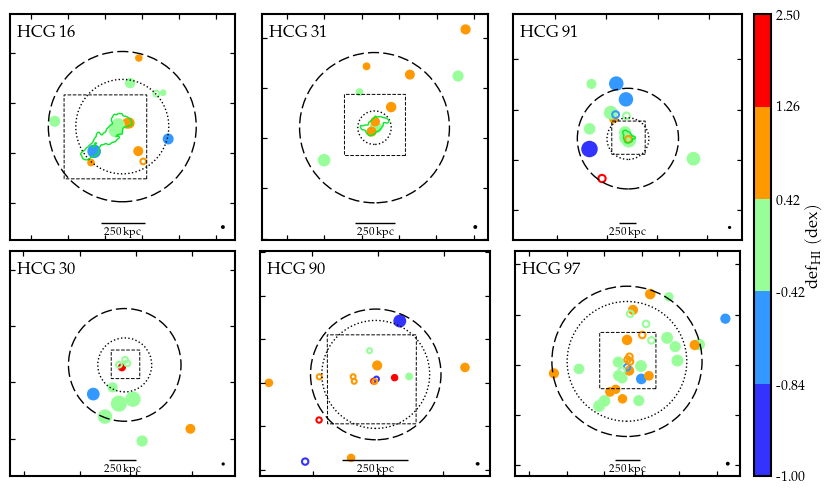

In [239]:
with open('group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('data_files.yml') as f:
    params = yaml.safe_load(f)

def scale_size(x, min_old, max_old, min_new, max_new):
    new_x = ((x - min_old) / (max_old - min_old)) * (max_new - min_new) + min_new
    return new_x

fig = plt.figure(figsize=(10,6))

glist = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']
phases = {2: ['HCG 16', 'HCG 31', 'HCG 91'],
         3: ['HCG 30', 'HCG 90', 'HCG 97']}

aspects = {'HCG 90': 0.85, 'HCG 91': 0.88}

grid = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.07])

dark_blue = (0.2, 0.2, 1.0)  # Dark blue
light_blue = (0.2, 0.6, 1.0)  # Light blue
green = (0.6, 1.0, 0.6)  # Green
orange = (1.0, 0.6, 0.0)  # Orange
red = (1.0, 0.0, 0.0)  # Red

colors = [dark_blue, light_blue, green, orange, red]
cmap = mpl.colors.LinearSegmentedColormap.from_list('BlueGreenRed', colors, N=256)

defhis = np.array([])
mhis = np.array([])
for i,g in enumerate(glist):
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    defhis = np.concatenate((defhis, df.defHI.values), axis=0)
    mhis = np.concatenate((mhis, df.logMHIobs.values), axis=0)

min_defhi, max_defhi = np.nanmin(defhis), np.nanmax(defhis)

min_defhi, max_defhi = np.floor(min_defhi * 2.)/2., np.ceil(max_defhi * 2.)/2.
bounds = sorted([max(-3,min_defhi), -0.84, -0.42, 0.42, 1.26, min(max_defhi, 3)])
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256, extend='neither')#(vmin=min_defhi, vmax=max_defhi)  # Adjust vmin and vmax based on your data

scale = u.Quantity(250.,unit='kpc')
scale_label = '250 kpc'
fontprops = FontProperties(size=8, family='monospace')

figdir = 'hidef_figures/'
print('Printing bmaj x bmin in kpc')
for i,g in enumerate(glist):
    if i < 3: ix, iy = 0, i
    else: ix, iy = 1, i-3
    grz, opthdr = fits.getdata('/mnt/scratch/HCGs/legacy_images/%s_grz.fits' %g.replace(' ',''), header=True)
    _, rband, _ = grz
    optwcs = WCS(opthdr).celestial
    try:
        pixsize = abs(opthdr['CDELT1'])
    except KeyError:
        pixsize = abs(opthdr['CD1_1'])
    
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    df.dropna(subset=['Name'], inplace=True)
    for k in phases.keys():
        if g in phases[k]: phase = k
    if phase == 2:
        df_gcore = df[df.Name.str.contains('core')]
    #     df_nocore = df[~df.Name.str.contains('core')]
    # elif phase == 3:
    #     df_nocore = df[~df.Name.str.contains('core: total')]
    df_nocore = df[~df.Name.str.contains('core: total')]
    mflag = df_nocore.MHIlim_flag
    df_nolim = df_nocore[mflag == 0]
    ra, dec, defhi, mhi = df_nolim.RA, df_nolim.Dec, df_nolim.defHI, df_nolim.logMHIobs
    ttype = df_nocore.T_type
    df_mlim = df_nocore[mflag == 1]
    rband[:] = np.nan
    
    ec = cmap(norm(df_nolim.defHI.values))

    levs = [nhi_3s_levels[g] * 1e18 * 2**(2*x) for x in range(10)]
    members = group_members[g]

    ax = fig.add_subplot(grid[ix,iy], aspect='equal', projection=optwcs)
    if g in aspects.keys():
        x0 = int(0.5*opthdr['NAXIS1'])
        npix_add = int((1.-aspects[g]) * opthdr['NAXIS1'])
        inflated_rband = np.full((opthdr['NAXIS1']+npix_add,opthdr['NAXIS1']), np.nan)
        inflated_rband[int(0.5*npix_add):opthdr['NAXIS1']+int(0.5*npix_add), :] = rband
        ax.imshow(inflated_rband, origin='lower', cmap='plasma', aspect=aspects[g])
    else:
        ax.imshow(rband, origin='lower', cmap='plasma')
       
    if 'core' in members.keys():
        cores = members['core']
        if 'core_center' in members.keys():
            core_cen = members['core_center']
            if len(core_cen) == 1:
                core_ra, core_dec = core_cen[0].split(',')
            else:
                print('Warning: there are more than 1 confusion centre coordinates; taking the first')
            cendata, cenhdr = utils.get_cubelet(g, float(core_ra), float(core_dec), params=params, peak=False)            
            nhi = utils.jy_to_cm2(cendata, cenhdr)
            hiwcs = WCS(cenhdr)
            # ax.contour(nhi, levels=levs, linewidths=1, colors='#0AE928', transform=ax.get_transform(hiwcs))
            ax.contour(nhi, levels=[levs[0]], linewidths=1, colors='#0AE928', transform=ax.get_transform(hiwcs))
    else:
        cenhdr = fits.getheader(params[g]['rootdir']+params[g]['moment_0'])
        
    bmaj, bmin, bpa = cenhdr['BMAJ'], hihdr['BMIN'], hihdr['BPA']
    bmaj, bmin = coords.Angle(bmaj, unit='deg'), coords.Angle(bmin, unit='deg')
    if np.isnan(bpa): bpa = 0.0

    s = 0.1 * 2**mhi
    sc = ax.scatter(ra, dec, c=defhi, s=s, marker='o', cmap=cmap, norm=norm, transform=ax.get_transform('world'))
    
    df_mlim = df_mlim[~np.isnan(df_mlim.defHI)]
    s_mlim = 0.1 * 2**df_mlim.logMHIobs
    ax.scatter(df_mlim.RA, df_mlim.Dec, ec=ec, fc='None', s=s_mlim, marker='o', lw=1.5, transform=ax.get_transform('world'))
    
    gra, gdec = utils.center_of_mass(g)
    pb = mpl.patches.Circle((gra, gdec), radius=0.5, ec='k', fc='None', ls=(0, (8, 3)), lw=1, transform=ax.get_transform('world'))
    ax.add_artist(pb)

    dist = u.Quantity(params[g]['distance'], unit='Mpc')
    
    Mvir, e_Mvir = utils.group_virial_mass(g)
    rvir_kpc, e_rvir =  utils.virial_radius_from_mass(Mvir, e_Mvir)

    rvir_angle = coords.Angle(float(rvir_kpc / dist.to('kpc').value), unit='radian')
    rvir_patch = mpl.patches.Circle((gra, gdec), radius=rvir_angle.degree, ec='k', fc='None', ls=':', lw=1, transform=ax.get_transform('world'))
    ax.add_artist(rvir_patch)
    
    boxcen, boxsize = hcg_boxes[g]['center'], hcg_boxes[g]['size']
    box_blc = (boxcen[0] - 0.5*boxsize, boxcen[1] - 0.5*boxsize)
    box = mpl.patches.Rectangle(box_blc, boxsize, boxsize, ec='k', fc='None', ls='--', lw=0.7,
                                zorder=10, transform=ax.get_transform('world'))
    ax.add_artist(box)
    
    ax.tick_params(which='both', direction='in')
    ax.coords[0].set_ticklabel_visible(False); ax.coords[1].set_ticklabel_visible(False)
    ax.text(0.03, 0.95, g, ha='left', va='top', size=12, transform=ax.transAxes)

    scale_angle = coords.Angle(float(scale.to('kpc').value / dist.to('kpc').value), unit='radian')
    scale_pix = scale_angle.degree / pixsize
    
    scalebar = AnchoredSizeBar(transform=ax.transData, size=scale_pix, label=scale_label, loc='lower center', pad=0.1, color='k', frameon=False, fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    el_x = ax.get_xlim()[1] - 0.5*bmaj.deg/pixsize - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])
    el_y = ax.get_ylim()[0] + 0.5*bmaj.deg/pixsize + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    beam = mpl.patches.Ellipse((el_x, el_y), width=bmin.deg/pixsize, height=bmaj.deg/pixsize, angle=bpa, lw=1, color='k', transform=ax.transData)  # in data coordinates!
    ax.add_artist(beam)
    
    bmaj_kpc = bmaj.to('radian').value * dist.to('kpc').value
    bmin_kpc = bmin.to('radian').value * dist.to('kpc').value
    
    print(f'{g}: ${bmaj_kpc:.1f}\\times{bmin_kpc:.1f}$')
cax = plt.subplot(grid[:, 3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = plt.colorbar(sm, cax=cax, pad=0.05, format=lambda x, _: f'{x:.2f}')
cb.set_label(label=r'$\rm def_{HI}\,\,(dex)$', size=12, labelpad=0.01)
cax.tick_params(axis='x', grid_linewidth=0, labeltop=False, top=False, labelbottom=False, bottom=False)
cax.tick_params(axis='y', labelsize=10, length=0, width=0, grid_linewidth=0, labelleft=False, left=False, labelright=True, right=False, direction='out')    

grid.update(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(figdir+'hidef_panels.pdf')

#### Zoom-in: HI def

/tmp/ipykernel_3387139/2993828632.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


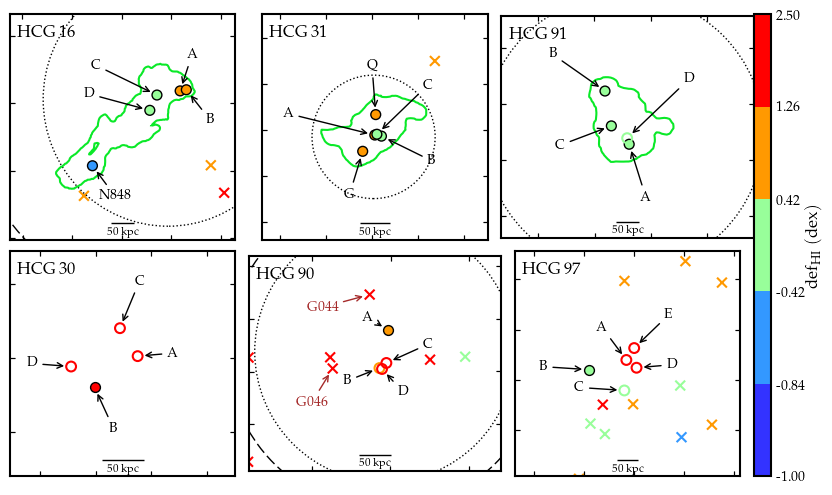

In [240]:
with open('group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('data_files.yml') as f:
    params = yaml.safe_load(f)

fig = plt.figure(figsize=(10,6))

grid = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.07])

defhis = np.array([])
mhis = np.array([])
for i,g in enumerate(glist):
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    defhis = np.concatenate((defhis, df.defHI.values), axis=0)
    mhis = np.concatenate((mhis, df.logMHIobs.values), axis=0)

min_defhi, max_defhi = np.nanmin(defhis), np.nanmax(defhis)

min_defhi, max_defhi = np.floor(min_defhi * 2.)/2., np.ceil(max_defhi * 2.)/2.
bounds = [max(-3,min_defhi), -0.84, -0.42, 0.42, 1.26, min(max_defhi, 3)]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256, extend='neither')

scale = u.Quantity(50.,unit='kpc')
scale_label = '50 kpc'
fontprops = FontProperties(size=8, family='monospace')

figdir = 'hidef_figures/'
for i,g in enumerate(glist):
    ix, iy = i // 3, i % 3
    
    grz, opthdr = fits.getdata('/mnt/scratch/HCGs/legacy_images/%s_grz.fits' %g.replace(' ',''), header=True)
    _, rband, _ = grz
    optwcs = WCS(opthdr).celestial
    try:
        pixsize = abs(opthdr['CDELT1'])
    except KeyError:
        pixsize = abs(opthdr['CD1_1'])
    
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    df.dropna(subset=['Name'], inplace=True)
    for k in phases.keys():
        if g in phases[k]: phase = k

    df_gcore = df[(~df.Name.str.contains('core: total')) & (df.Name.str.contains('core'))]
    df_out = df[~df.Name.str.contains('core')]
    # if phase == 2:
    #     df_gcore = df[df.Name.str.contains('core')]
    #     df_nocore = df[~df.Name.str.contains('core')]
    # elif phase == 3:
    #     df_nocore = df[~df.Name.str.contains('core: total')]
    mflag = df_gcore.MHIlim_flag
    df_nolim = df_gcore[mflag == 0]
    ra, dec, defhi, mhi = df_nolim.RA, df_nolim.Dec, df_nolim.defHI, df_nolim.logMHIobs
    df_mlim = df_gcore[mflag == 1]
    rband[:] = np.nan

    levs = [nhi_3s_levels[g] * 1e18 * 2**(2*x) for x in range(10)]
    ec = cmap(norm(df_gcore.defHI.values))

    members = group_members[g]

    boxcen, boxsize = hcg_boxes[g]['center'], hcg_boxes[g]['size']
    sub_coo = coords.SkyCoord(boxcen[0],boxcen[1], unit='deg', frame='icrs')
    cutout = Cutout2D(rband, position=sub_coo, size=coords.Angle(boxsize,unit='deg'), wcs=optwcs)

    ax = fig.add_subplot(grid[ix,iy], aspect='equal', projection=cutout.wcs)
    cutout_data = cutout.data
    if g in aspects.keys():
        # cutout_size = max(cutout_data.shape[0], cutout_data.shape[1])
        # x0 = int(0.5*cutout_size)
        # npix_add = int((1.-aspects[g]) * cutout_size)
        # inflated_cutout = np.full((cutout_size+npix_add,cutout_size), np.nan)
        # inflated_cutout[int(0.5*npix_add):cutout_size+int(0.5*npix_add), :] = cutout_data
        ax.imshow(cutout_data, origin='lower', cmap='plasma', aspect=aspects[g])
    else:
        ax.imshow(cutout_data, origin='lower', cmap='plasma')
    # ax.imshow(cutout.data, origin='lower', cmap='plasma')
    
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    
    if 'core' in members.keys():
        cores = members['core']
        if 'core_center' in members.keys():
            core_cen = members['core_center']
            if len(core_cen) == 1:
                core_ra, core_dec = core_cen[0].split(',')
            else:
                print('Warning: there are more than 1 confusion centre coordinates; taking the first')
            cendata, cenhdr = utils.get_cubelet(g, float(core_ra), float(core_dec), params=params, peak=False)            
            nhi = utils.jy_to_cm2(cendata, cenhdr)
            hiwcs = WCS(cenhdr)
            # ax.contour(nhi, levels=levs, linewidths=1, colors='#0AE928', transform=ax.get_transform(hiwcs))
            ax.contour(nhi, levels=[levs[0]], linewidths=1.5, colors='#0AE928', transform=ax.get_transform(hiwcs))
    
    sc = ax.scatter(ra, dec, c=defhi, s=50, marker='o', ec='k', cmap=cmap, norm=norm, transform=ax.get_transform('world'))
    ax.scatter(df_out.RA, df_out.Dec, c=df_out.defHI, s=50, marker='x', cmap=cmap, norm=norm, transform=ax.get_transform('world'))
    
    df_mlim = df_mlim[~np.isnan(df_mlim.defHI)]
    s_mlim = 0.1 * 2**df_mlim.logMHIobs
    ax.scatter(df_mlim.RA, df_mlim.Dec, ec=ec, fc='None', s=50, marker='o', lw=1.5, transform=ax.get_transform('world'))

    with open('annotate_coords.yaml') as f:
        ann_xys = yaml.safe_load(f)
    if g == 'HCG 90':
        extra_members = ['ESO 466- G 044', 'ESO 466- G 046']
        df_gcore = pd.concat([df_gcore, df[df.Name.isin(extra_members)]], ignore_index=True)
    color = 'k'
    for i_row, row in df_gcore.iterrows():
        mem, ra_i, dec_i = row.Name, row.RA, row.Dec
        mem = mem.replace('core: ','').replace('NGC 0848', 'N848')
        mem = mem.replace('core: ','').replace('ESO 466- G 044', 'G044')
        mem = mem.replace('core: ','').replace('ESO 466- G 046', 'G046')
        if mem.split()[0] == 'HCG':
            mem = mem.split()[1][-1]
        if mem in ['G044', 'G046']:
            color = 'brown'
        ann_xy = ann_xys[g]
        xyi = ann_xy[mem]
        ax.annotate(mem, xy=(ra_i, dec_i), xytext=(ra_i+xyi[0]/60., dec_i+xyi[1]/60.),
                    arrowprops=dict(arrowstyle='->', color=color, shrinkB=5),
                    xycoords=ax.get_transform('world'), color=color, fontsize=10, zorder=50)
    
    gra, gdec = utils.center_of_mass(g)
    pb = mpl.patches.Circle((gra, gdec), radius=0.5, ec='k', fc='None', ls=(0, (8, 3)), lw=1, transform=ax.get_transform('world'))
    ax.add_artist(pb)
    
    dist = u.Quantity(params[g]['distance'], unit='Mpc')
    
    Mvir, e_Mvir = utils.group_virial_mass(g)
    rvir_kpc, e_rvir =  utils.virial_radius_from_mass(Mvir, e_Mvir)

    rvir_angle = coords.Angle(float(rvir_kpc / dist.to('kpc').value), unit='radian')
    rvir_patch = mpl.patches.Circle((gra, gdec), radius=rvir_angle.degree, ec='k', fc='None', ls=':', lw=1, transform=ax.get_transform('world'))
    ax.add_artist(rvir_patch)
    
    ax.tick_params(which='both', direction='in')
    ax.coords[0].set_ticklabel_visible(False); ax.coords[1].set_ticklabel_visible(False)
    ax.text(0.03, 0.95, g, ha='left', va='top', size=12, transform=ax.transAxes)

    scale_angle = coords.Angle(float(scale.to('kpc') / dist.to('kpc')), unit='radian')
    scale_pix = scale_angle.degree / pixsize
    
    scalebar = AnchoredSizeBar(transform=ax.transData, size=scale_pix, label=scale_label, loc='lower center', pad=0.1, color='k', frameon=False, fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    
cax = plt.subplot(grid[:, 3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = plt.colorbar(sm, cax=cax, pad=0.05, format=lambda x, _: f'{x:.2f}')
cb.set_label(label=r'$\rm def_{HI}\,\,(dex)$', size=12, labelpad=0.01)
cax.tick_params(axis='x', grid_linewidth=0, labeltop=False, top=False, labelbottom=False, bottom=False)
cax.tick_params(axis='y', labelsize=10, length=0, width=0, grid_linewidth=0, labelleft=False, left=False, labelright=True, right=False, direction='out')    

grid.update(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(figdir+'hidef_panels_zoom.pdf')

#### Morphology distribution

/tmp/ipykernel_3387139/106305568.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


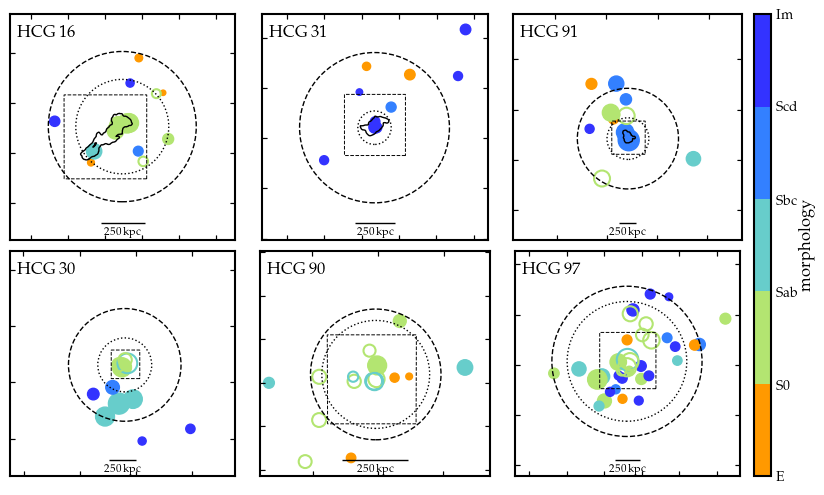

In [241]:
with open('/mnt/scratch/HCGs/group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('/mnt/scratch/HCGs/data_files.yml') as f:
    params = yaml.safe_load(f)

fig = plt.figure(figsize=(10,6))

glist = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']
grid = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.07])

dark_blue = (0.2, 0.2, 1.0)  # Dark blue
light_blue = (0.2, 0.6, 1.0)  # Light blue
green = (0.6, 1.0, 0.6)  # Green
orange = (1.0, 0.6, 0.0)  # Orange
red = (1.0, 0.0, 0.0)  # Red

colors = [orange, green, light_blue, dark_blue]
cmap = mpl.colors.LinearSegmentedColormap.from_list('RedGreenBlue', colors, N=256)

bounds = [-5, 0, 2, 4, 6, 10]
mtypes = ['E', 'S0', 'Sab', 'Sbc', 'Scd', 'Im']
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256, extend='neither')  # Adjust vmin and vmax based on your data

scale = u.Quantity(250.,unit='kpc')
scale_label = '250 kpc'
fontprops = FontProperties(size=8, family='monospace')

for i,g in enumerate(glist):
    if i < 3: ix, iy = 0, i
    else: ix, iy = 1, i-3
    grz, opthdr = fits.getdata('/mnt/scratch/HCGs/legacy_images/%s_grz.fits' %g.replace(' ',''), header=True)
    _, rband, _ = grz
    optwcs = WCS(opthdr).celestial
    try:
        pixsize = abs(opthdr['CDELT1'])
    except KeyError:
        pixsize = abs(opthdr['CD1_1'])
    
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    df.dropna(subset='Name', inplace=True)
    for k in phases.keys():
        if g in phases[k]: phase = k
    if phase == 2:
        df_gout = df[df.Name.str.contains('core')]
    # elif phase == 3:
    #     df_nocore = df[~df.Name.str.contains('core: total')]
    df_nocore = df[~df.Name.str.contains('core: total')]

    mflag = df_nocore.MHIlim_flag
    df_nolim = df_nocore[mflag == 0]
    ra, dec, defhi, mhi = df_nolim.RA, df_nolim.Dec, df_nolim.defHI, df_nolim.logMHIobs
    ttype = df_nolim.T_type
    df_mlim = df_nocore[mflag == 1]
    rband[:] = np.nan

    levs = [nhi_3s_levels[g] * 1e18 * 2**(2*x) for x in range(10)]

    members = group_members[g]
    
    ax = fig.add_subplot(grid[ix,iy], aspect='equal', projection=optwcs)
    if g in aspects.keys():
        x0 = int(0.5*opthdr['NAXIS1'])
        npix_add = int((1.-aspects[g]) * opthdr['NAXIS1'])
        inflated_rband = np.full((opthdr['NAXIS1']+npix_add,opthdr['NAXIS1']), np.nan)
        inflated_rband[int(0.5*npix_add):opthdr['NAXIS1']+int(0.5*npix_add), :] = rband
        ax.imshow(inflated_rband, origin='lower', cmap='plasma', aspect=aspects[g])
    else:
        ax.imshow(rband, origin='lower', cmap='plasma')
        
    if 'core' in members.keys():
        cores = members['core']
        if 'core_center' in members.keys():
            core_cen = members['core_center']
            if len(core_cen) == 1:
                core_ra, core_dec = core_cen[0].split(',')
            else:
                print('Warning: there are more than 1 confusion centre coordinates; taking the first')
            cendata, cenhdr = utils.get_cubelet(g, float(core_ra), float(core_dec), params=params, peak=False)            
            nhi = utils.jy_to_cm2(cendata, cenhdr)
            hiwcs = WCS(cenhdr)
            # ax.contour(nhi, levels=levs, linewidths=0.3, colors='gray', transform=ax.get_transform(hiwcs))
            ax.contour(nhi, levels=[levs[0]], linewidths=1, colors='k', transform=ax.get_transform(hiwcs))
    
    s = 0.1 * 2**df_nolim.logMs
    sc = ax.scatter(ra, dec, c=ttype, s=s, marker='o', cmap=cmap, norm=norm, transform=ax.get_transform('world'))
    
    df_mlim = df_mlim[~np.isnan(df_mlim.T_type)]
    s_mlim = 0.1 * 2**df_mlim.logMs
    ec = cmap(norm(df_mlim.defHI.values))
    ax.scatter(df_mlim.RA, df_mlim.Dec, ec=ec, fc='None', s=s_mlim, marker='o', lw=1.5, transform=ax.get_transform('world'))
    
    gra, gdec = utils.center_of_mass(g)
    pb = mpl.patches.Ellipse((gra, gdec), width=1, height=1, angle=0, ec='k', fc='None', ls='--', transform=ax.get_transform('world'))
    ax.add_artist(pb)
    
    dist = u.Quantity(params[g]['distance'], unit='Mpc')
    
    Mvir, e_Mvir = utils.group_virial_mass(g)
    rvir_kpc, e_rvir =  utils.virial_radius_from_mass(Mvir, e_Mvir)

    rvir_angle = coords.Angle(float(rvir_kpc / dist.to('kpc').value), unit='radian')
    rvir_patch = mpl.patches.Circle((gra, gdec), radius=rvir_angle.degree, ec='k', fc='None', ls=':', lw=1, transform=ax.get_transform('world'))
    ax.add_artist(rvir_patch)

    boxcen, boxsize = hcg_boxes[g]['center'], hcg_boxes[g]['size']
    box_blc = (float(boxcen[0]) - 0.5*boxsize, float(boxcen[1]) - 0.5*boxsize)
    box = mpl.patches.Rectangle(box_blc, boxsize, boxsize, ec='k', fc='None', ls='--', lw=0.7,
                                zorder=10, transform=ax.get_transform('world'))
    ax.add_artist(box)

    ax.tick_params(which='both', direction='in')
    ax.coords[0].set_ticklabel_visible(False); ax.coords[1].set_ticklabel_visible(False)
    ax.text(0.03, 0.95, g, ha='left', va='top', size=12, transform=ax.transAxes)

    scale_angle = coords.Angle(float(scale.to('kpc') / dist.to('kpc')), unit='radian')
    scale_pix = scale_angle.degree / pixsize

    scalebar = AnchoredSizeBar(transform=ax.transData, size=scale_pix, label=scale_label, loc='lower center', pad=0.1, color='k', frameon=False, fontproperties=fontprops)
    ax.add_artist(scalebar)
    
cax = plt.subplot(grid[:, 3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = plt.colorbar(sm, cax=cax, pad=0.05)
cb.set_label(label=r'$\rm morphology$', size=12, labelpad=0.1)
cb.ax.set_yticklabels(mtypes)
cax.tick_params(axis='x', grid_linewidth=0, labeltop=False, top=False, labelbottom=False, bottom=False)
cax.tick_params(axis='y', labelsize=10, length=0, width=0, grid_linewidth=0, labelleft=False, left=False, labelright=True, right=False, direction='out')    

grid.update(wspace=0., hspace=0.05)
plt.tight_layout()
plt.savefig(figdir+'ttype_panels.pdf')

### HI-def distributions of outskirts: separation at Rvir

In [246]:
def sep_by_rvir(phase, stats=False):
    if phase in [2,3]:
        pn = phase
        gl = phases[phase]
    else:
        pn = 'all'
        gl = glist
    df_all = pd.DataFrame()
    for g in gl:
        df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
        df.dropna(subset=['Name'], inplace=True)
        df_nocore = df[~df.Name.str.contains('core:')]
        df_all = pd.concat([df_all, df_nocore], ignore_index=True)
    sep_norm_, defhi_ = df_all.sep_norm.values, df_all.defHI.values
    m_ = (np.isnan(sep_norm_)) | np.isnan(defhi_)
    sep_norm, defhi = sep_norm_[~m_], defhi_[~m_]
    m_int = sep_norm < 1.
    m_ext = sep_norm > 1.


    sep_norm_int, defhi_int = sep_norm[m_int], defhi[m_int]
    sep_norm_ext, defhi_ext = sep_norm[m_ext], defhi[m_ext]
    
    rho_all, p_value_all = spearmanr(sep_norm, defhi)
    
    median_int, std_int = np.median(defhi_int), np.std(defhi_int)/np.sqrt(defhi_int.size)
    median_ext, std_ext = np.median(defhi_ext), np.std(defhi_ext)/np.sqrt(defhi_ext.size)
    rho_int, p_value_int = spearmanr(sep_norm_int, defhi_int)
    rho_ext, p_value_ext = spearmanr(sep_norm_ext, defhi_ext)
    if stats:
        print(f'Phase {pn}:')
        print(f'All R:\n\trho = {rho_all:.3f} -- p = {p_value_all:.3f}')
        print(f'R < 1 Rv:\n\trho = {rho_int:.3f} -- p = {p_value_int:.3f}\n\tmedian = {median_int:.2f} -- std = {std_int:.2f}')
        print(f'R > 1 Rv:\n\trho = {rho_ext:.3f} -- p = {p_value_ext:.3f}\n\tmedian = {median_ext:.2f} -- std = {std_ext:.2f}')
    return sep_norm_int, sep_norm_ext, defhi_int, defhi_ext

In [247]:
### Print phase 2 stats:
_, _, _, _ = sep_by_rvir(2, stats=True)

Phase 2:
All R:
	rho = -0.304 -- p = 0.123
R < 1 Rv:
	rho = -0.500 -- p = 0.667
	median = 0.62 -- std = 0.44
R > 1 Rv:
	rho = -0.250 -- p = 0.238
	median = 0.35 -- std = 0.13


In [248]:
### Print phase 3 stats:
_, _, _, _ = sep_by_rvir(3, stats=True)

Phase 3:
All R:
	rho = -0.292 -- p = 0.044
R < 1 Rv:
	rho = -0.246 -- p = 0.191
	median = 0.46 -- std = 0.12
R > 1 Rv:
	rho = -0.079 -- p = 0.754
	median = 0.30 -- std = 0.16


In [249]:
### Print all sample stats:
_, _, _, _ = sep_by_rvir(0, stats=True)

Phase all:
All R:
	rho = -0.276 -- p = 0.017
R < 1 Rv:
	rho = -0.207 -- p = 0.247
	median = 0.47 -- std = 0.11
R > 1 Rv:
	rho = -0.186 -- p = 0.239
	median = 0.35 -- std = 0.10


### LaTeX table: deficiency statistics for core and outskirts

In [250]:
header = '\\begin{table*}\n\
\\begin{center}\n\
\\caption{Distibutions of \\hi\ deficiency in galaxies in the cores and outskirts of the HCGs.}\
\\label{tab:hidef_stats}\n\
\\begin{tabular}{c c c c c c c c} \n\
\\hline \n\
\\hline \n\
\\multirow{2}{*}{Phase} & \\multirow{2}{*}{HCG} & \\multicolumn{3}{c}{core} & \\multicolumn{3}{c}{outskirts} \\\\ \n\
\\cmidrule(lr){3-5}  \\cmidrule(l){6-8} \n\
& & \\% rich & \\% normal & \\% poor & \\% rich & \\% normal & \\% poor \\\\ \n\
\\hline \\rule{0pt}{10pt} \n'
fout = open('/mnt/scratch/HCGs/tables/hidef_stats.tex', 'w')
fout.write(header)

for i, hcg in enumerate(glist):
    g = hcg.split()[-1]
    df = pd.read_csv(f'params_tables/HIdef_hcg{g}.csv', na_values='--')
    df.dropna(subset=['Name'], inplace=True)
    for k in phases.keys():
        if hcg in phases[k]: phase = k

    df_c = df[df.Name.str.contains('core')]
    df_c = df_c[~df_c.Name.str.contains('core: total')]
    df_c = df_c[~np.isnan(df_c.defHI)]
    
    df_nc = df[~df.Name.str.contains('core')]
    df_nc = df_nc[~np.isnan(df_nc.defHI)]
    df_nc = df_nc[~np.isnan(df_nc.defHI)]

    df_c_poor = df_c[df_c.defHI >= 0.25]
    df_c_rich = df_c[df_c.defHI <= -0.25]
    df_c_norm = df_c[(df_c.defHI > -0.25) & (df_c.defHI < 0.25)]
    
    df_nc_poor = df_nc[df_nc.defHI >= 0.25]
    df_nc_rich = df_nc[df_nc.defHI <= -0.25]
    df_nc_norm = df_nc[(df_nc.defHI > -0.25) & (df_nc.defHI < 0.25)]

    f_poor_c = 100*len(df_c_poor)/len(df_c)
    f_poor_c_lim = 100*len(df_c_poor[df_c_poor.MHIlim_flag == 1])/len(df_c)
    f_norm_c = 100*len(df_c_norm)/len(df_c)
    f_norm_c_lim = 100*len(df_c_norm[df_c_norm.MHIlim_flag == 1])/len(df_c)
    f_rich_c = 100*len(df_c_rich)/len(df_c)
    f_rich_c_lim = 100*len(df_c_rich[df_c_rich.MHIlim_flag == 1])/len(df_c)
    
    f_poor_nc = 100*len(df_nc_poor)/len(df_nc)
    f_norm_nc = 100*len(df_nc_norm)/len(df_nc)
    f_rich_nc = 100*len(df_nc_rich)/len(df_nc)
    
    try:
        nfrac_rich = f_rich_c_lim/f_rich_c
    except:
        nfrac_rich = 0.
    try:
        nfrac_norm = f_norm_c_lim/f_norm_c
    except:
        nfrac_norm = 0.
    try:
        nfrac_poor = f_poor_c_lim/f_poor_c
    except:
        nfrac_poor = 0.  
    stars = {0.: '', 1.: 'a', 0.5:'c', 0.75:'b'}
    if i < 2:
        if i == 0:
            line = '\\multirow{3}{*}{2} & %s & %d & %d & %d & %d & %d & %d\\\\ \n' %(g,f_rich_c,f_norm_c,f_poor_c,f_rich_nc,f_norm_nc,f_poor_nc)
        else:
            line = ' & %s & %d & %d & %d & %d & %d & %d\\\\ \n' %(g,f_rich_c,f_norm_c,f_poor_c,f_rich_nc,f_norm_nc,f_poor_nc)
    else:
        if i == 3:
            line = '\\hline\\rule{0pt}{10pt}\n \\multirow{3}{*}{3} & %s & $%d^{%s}$ & $%d^{%s}$ & $%d^{%s}$ & %d & %d & %d\\\\ \n' %(g,f_rich_c,stars[nfrac_rich],f_norm_c,stars[nfrac_norm],f_poor_c,stars[nfrac_poor],f_rich_nc,f_norm_nc,f_poor_nc)
        else:
            line = ' & %s & $%d^{%s}$ & $%d^{%s}$ & $%d^{%s}$ & %d & %d & %d\\\\ \n' %(g,f_rich_c,stars[nfrac_rich],f_norm_c,stars[nfrac_norm],f_poor_c,stars[nfrac_poor],f_rich_nc,f_norm_nc,f_poor_nc)
    fout.write(line)
fout.write('\\hline\n')
fout.write('\\end{tabular}\\\\ \n\
{\\footnotesize \n\
Notes: \n\
$^{%s}$No \hi\ detection. \n\
$^{%s}$Only 1/4 were detected in \hi.} \n\
\\end{center} \n\
\\end{table*}' %(stars[1], stars[0.75]))
fout.close()

### Print the mass limit for each HCG

In [251]:
for g in group_list:
    noise_cube = params[g]['rootdir'] + '/' + params[g]['noise_cube']
    group_dist = params[g]['distance']
    group_vsys = params[g]['velocity']
    # group_diam = virial_radius(g)
    cra, cdec = utils.center_of_mass(g)
    ccoo = coords.SkyCoord(cra, cdec, unit='deg', frame='icrs')
    
    noise_data, noise_hdr = fits.getdata(noise_cube, header=True)
    noise_median = np.nanmedian(noise_data, axis=0)
    cell_size = abs(noise_hdr['CDELT1'])
    cell_area = cell_size * cell_size
    bmaj, bmin = noise_hdr['BMAJ'], noise_hdr['BMIN']
    beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0) * cell_area)
    wcs = WCS(noise_hdr).celestial
    vdelt = np.abs(noise_hdr['CDELT3'])
    if vdelt > 1e3: vdelt *= 1e-3
    
    fluxlim = utils.flux_limit(data=noise_median, wcs=wcs, ra=cra, dec=cdec, size=bmaj, vdelt=vdelt, beam_area=beam_area)
    mhilim = utils.himass(fluxlim, group_dist)
    print(f'{g}: {fluxlim:.2f} - {mhilim:.1f}')

/tmp/ipykernel_3387139/716368072.py:10: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)


TypeError: unsupported format string passed to tuple.__format__

#### Print measured and predicted core mass for each HCG

In [174]:
glist = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']

for g in glist:
    df = pd.read_csv('params_tables/HIdef_%s.csv' %g.replace(' ','').lower(), na_values='--')
    df.dropna(subset=['Name'], inplace=True)
    df_totcore = df[df.Name.str.contains('core: total')]
    mobs = df_totcore.logMHIobs.values[0]
    mpred = df_totcore.logMHIexp.values[0]
    print(f'{g}: {10**mobs:.2e} - {10**mpred:.2e}')

HCG 16: 2.14e+10 - 1.03e+10
HCG 31: 1.69e+10 - 8.05e+09
HCG 91: 1.92e+10 - 2.09e+10
HCG 30: 1.65e+08 - 6.15e+09
HCG 90: 4.43e+08 - 6.93e+09
HCG 97: 1.09e+09 - 1.64e+10


### LaTeX table: HCG properties

In [252]:
with open('group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('data_files.yml') as f:
        params = yaml.safe_load(f)

glist = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']
phase = {2: ['HCG 16', 'HCG 31', 'HCG 91'],
         3: ['HCG 30', 'HCG 90', 'HCG 97']}

header = "\\begin{table*}\n\
    \centering\n\
    \caption{Properties of the HCGs. Columns list: (1) the HCG phase; (2) the HCG group ID; (3) the J2000 coordinates as computed from this work (see \\Cref{sec:optical:centres}); (4) the heliocentric systemic velocity from \\citet{Jones2023}; \
    (5) the group's velocity dispersion; (6) the group's distance from \\citet{Jones2023}; (7) The virial mass of the group; (8) the virial radius of the group based on its velocity dispersion; (9) the number of group members considered. See text for details on derived properties.}\n\
    \label{tab:hcg_props}\n\
    \\begin{tabular}{c c c c c c c c c c}\n\
    \hline \hline \n\
\multirow{2}{*}{Phase} & \multirow{2}{*}{HCG} & RA & Dec & $V_{\\rm sys}$ & $\\sigma_{v}$ & Dist. & $M_{\\rm vir}$ & $r_{\\rm vir}$ & \multirow{2}{*}{$\\rm N$}\\\\ \n\
 & & \multicolumn{2}{c}{(J2000)} & ($\\rm km\,s^{-1}$) & ($\\rm km\,s^{-1}$) & (Mpc) & ($10^{12}\\,M_\\odot$) & (kpc) & \\\\ \n\
(1) & (2) & \multicolumn{2}{c}{(3)} & (4) & (5) & (6) & (7) & (8) & (9) \\\\ \n"
 
fout = open('/mnt/scratch/HCGs/tables/hcg_props.tex', 'w')
fout.write(header)

for g in glist:
    gno = g.split()[-1]
    df = pd.read_csv(f'params_tables/HIdef_hcg{gno}.csv', na_values='--')
    df.dropna(subset=['Name'], inplace=True)
    df_c = df[(df.Name.str.contains('core')) & (~df.Name.str.contains('core: total'))]
    df_o = df[~df.Name.str.contains('core') & (~df.Name.str.contains('all'))]
    
    for k in phase.keys():
        if g in phase[k]: p = k
    gpar = params[g]
    vsys, dist, n_mem = gpar['velocity'], gpar['distance'], gpar['n_members']
    cm_ra, cm_dec = utils.center_of_mass(g)
    cm_coo = coords.SkyCoord(cm_ra, cm_dec, unit='deg', frame='icrs')
    cm_ras, cm_decs = cm_coo.ra.to_string(unit=u.hourangle, sep=':', precision=2, pad=True), cm_coo.dec.to_string(sep=':', precision=2, pad=True)
    
    vdisp = utils.velocity_dispersion(g)
    # rvir_angle = coords.Angle(utils.virial_radius(g), unit='arcmin')
    Mvir, e_Mvir = utils.group_virial_mass(g)
    rvir_kpc, e_rvir = utils.virial_radius_from_mass(Mvir, e_Mvir) #rvir_angle.radian * dist * 1e3
    Mvir *= 1e-12; e_Mvir *= 1e-12
    if g in ['HCG 16', 'HCG 30']:
        fout.write('\hline \\rule{0pt}{10pt} \n\multirow{3}{*}{%d} & %s & %s & %s & %d & %.1f & %d & $%.1f\\pm%.1f$ & $%.1f\\pm%.1f$ & %d\\\\ \n' %(p, g.split()[-1], cm_ras, cm_decs, vsys, vdisp, dist, Mvir, e_Mvir, rvir_kpc, e_rvir, n_mem))
    else:
        fout.write(' & %s & %s & %s & %d & %.1f & %d & $%.1f\\pm%.1f$ & $%.1f\\pm%.1f$ & %d\\\\ \n' %(g.split()[-1], cm_ras, cm_decs, vsys, vdisp, dist, Mvir, e_Mvir, rvir_kpc, e_rvir, n_mem))
fout.write('\hline\n\
\end{tabular}\n\
\end{table*}')
fout.close()

### LaTeX table: individual galaxy masses

In [253]:
### Crop FITS files (image and mask) for each P2 HCG
### Note, this was updated and will not overwrite old files currently in use.
### Instead, it will write new FITS that will not be used in the following. Update accordingly after testing.
# for hcg in [16, 31, 91]:
#     utils.crop_hcg_fits(hcg, input_type='image')
#     utils.crop_hcg_fits(hcg, input_type='mask')

### Calculate MHI for individual members of P2 HCGs
df_indv = pd.DataFrame()
for hcg in [16, 31, 91]:
    # Uncomment to re-calculate MHI (and plot moment maps if wanted)
    # df_ = utils.calculate_individual_masses(hcg, show_plot=False)
    
    # Uncomment to read data from file
    df_ = pd.read_csv(f'/mnt/scratch/HCGs/individual_masses_hcg{hcg}.csv')
    
    df_indv = df_indv._append(df_, ignore_index=True)

In [255]:
df_indv

,Unnamed: 0,HCG,member,logMHI
0,0,16,16B,8.939889
1,1,16,16A,8.746008
2,2,16,16C,9.578616
3,3,16,16D,9.551860
4,4,16,NGC0848,9.598250
5,5,16,total,10.105380
6,0,31,31Q,8.468373
7,1,31,31B,8.945310
8,2,31,31C,8.808641
9,3,31,31A,8.538609


In [257]:
### Write out LaTeX table

header = '\\begin{table}\n\
\\begin{center}\n\
\\caption{\\hi\ masses of individual HCG core members. The top and bottom halves respectively include the Phase 2 and 3 groups.\
The last two columns respectively list the \hi\ masses inside and outside the discs of the member galaxies.}\
\\label{tab:mass_members}\n\
\\begin{tabular}{l l c c} \n\
\\hline \n\
\\hline \n\
\\multirow{2}{*}{HCG} & \\multirow{2}{*}{member} & $\\rm\log{M_{\\textsc{Hi}, gal}}$ & $\\rm\log{M_{\hi,ext}}$ \\\\ \n\
 & & $\\rm (M_\odot)$ & $\\rm (M_\odot)$ \\\\ \n\
\\hline \\rule{0pt}{10pt}\n'
fout = open('/mnt/scratch/HCGs/tables/tab_mems_phase2_3.tex', 'w')
fout.write(header)

gs = [16, 31, 91]
df_groups = df_indv.groupby('HCG')

for g in gs:
    dfg = df_groups.get_group(g)
    dfg.reset_index().drop(columns='index', inplace=True)
    dfg = dfg.sort_values(by='member', ignore_index=True)
    df_pars = pd.read_csv(f'/mnt/scratch/HCGs/params_tables/HIdef_hcg{g}.csv')
    df_pars.dropna(subset=['Name'], inplace=True)
    mtot = 10**df_pars[df_pars.Name=='core: total'].logMHIobs.values[0]
    for i,row in dfg.iterrows():
        row.member = row.member.replace('WJ','LEDA 749936$^*$')
        if i == 0:
            line = ' \\multirow{%d}{*}{%d} & %s & %.1f & --\\\\ \n' %(len(dfg),g,row.member.replace('NGC','N').replace('AD','A'),row.logMHI)
        elif i == len(dfg)-1:
            mgal = 10**row.logMHI
            mgas = np.log10(mtot - mgal)
            line = ' & {\\bf %s} & {\\bf %.1f} & {\\bf %.1f}\\\\ \n' %(row.member,row.logMHI, mgas)
            if g != 91:
                line += '\\rule{0pt}{10pt}\n'
        else:
            line = ' & %s & %.1f & -- \\\\ \n' %(row.member.replace('NGC','N').replace('AD','A'),row.logMHI)
        fout.write(line)
    # fout.write('\\hline\n')
fout.write('\\hline\n')
fout.write('\\rule{0pt}{10pt}\n')
for g in [30, 90, 97]:
    df_pars = pd.read_csv(f'/mnt/scratch/HCGs/params_tables/HIdef_hcg{g}.csv')
    df_pars.dropna(subset=['Name'], inplace=True)
    dfc = df_pars[df_pars.Name.str.contains('core')]
    dfc = dfc.sort_values(by='Name', ignore_index=True)
    mtot = 10**dfc[dfc.Name=='core: total'].logMHIobs.values[0]
    for i,row in dfc.iterrows():
        # print(row.Name.split()[-1], '%.2f' %row.logMHIobs, '%.2f' %np.log10(mtot))
        if row.MHIlim_flag == 1:
            symb = '<'
        else:
            symb = ''
        if i == 0:
            line = ' \\multirow{%d}{*}{%d} & %s & ${%s}%.1f$ & --\\\\ \n' %(len(dfc),g,row.Name.split()[-1],symb,row.logMHIobs)
        elif i == len(dfc)-1:
            if g == 90:
                hidata, hihdr = fits.getdata(params[f'HCG {g}']['rootdir']+params[f'HCG {g}']['moment_0'], header=True)
                hiwcs = WCS(hihdr)
                reg = Regions.read(f'box_regions/hcg{g}_tail.reg', format='crtf')
                pixel_reg = reg[0].to_pixel(hiwcs)
                reg_mask = pixel_reg.to_mask(mode='center').to_image(hidata.shape)
                masked_hidata = hidata * reg_mask
                masked_hidata[reg_mask == 0] = np.nan
                
                ext_f = utils.totflux(masked_hidata, hihdr)
                ext_logm, _ = utils.himass(ext_f, params[f'HCG {g}']['distance'])
                ext_m = 10**ext_logm
                line = ' & {\\bf %s} & ${\\bf {\\leq}%.1f}$ & {\\bf %.1f}\\\\ \n' %(row.Name.split()[-1],row.logMHIobs, np.log10(ext_m))
                line += '\\rule{0pt}{10pt}\n'
            else:
                line = ' & {\\bf %s} & ${\\bf {\\leq}%.1f}$ & {\\bf --}\\\\ \n' %(row.Name.split()[-1],row.logMHIobs)
                if g != 97:
                    line += '\\rule{0pt}{10pt}\n'
        else:
            line = ' & %s & ${%s}%.1f$ & -- \\\\ \n' %(row.Name.split()[-1],symb,row.logMHIobs)
        fout.write(line)
    # fout.write('\\hline\n')      
    # fout.write(' \\rule{0pt}{15pt}\n')
fout.write('\\hline\n')
fout.write('\\end{tabular} \\\\ \n\
\\rule{0pt}{10pt}\n\
Note: $^*$ LEDA 749936 (WISEA J220854.95-274701.6) coincides spatially with the peak of an \hi\ cloud in the core of HCG 91, \
but lacks an optical readshift; we include it in this table but do not count it as a core member.\n\
\\end{center} \n\
\\end{table}')
fout.close()

### Plot individual HI discs (not included in paper)

13.8, 13.7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
15.4, 15.2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
25.9, 25.0
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong
check moment 0 units, considering "Jy/beam.km/s" but could be wrong


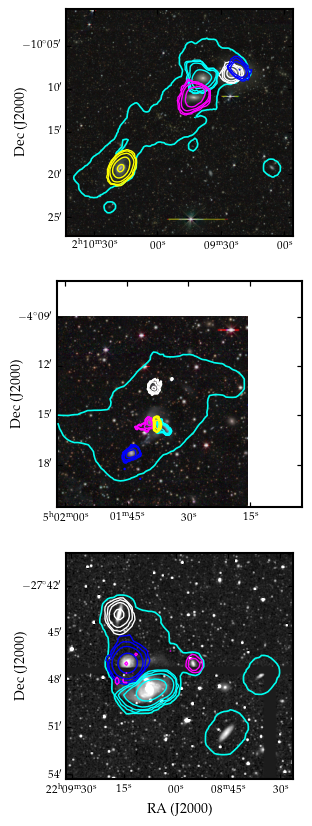

In [328]:
with open('/mnt/scratch/HCGs/group_members.yml') as f:
    group_members = yaml.safe_load(f)
with open('/mnt/scratch/HCGs/data_files.yml') as f:
    params = yaml.safe_load(f)
with open('/mnt/scratch/HCGs/separate_hi_discs/ids_to_galnames.yml') as fp:
    ids_to_galnames = yaml.safe_load(fp)
     
fig = plt.figure(figsize=(8,10))

p2_list = ['HCG 16', 'HCG 31', 'HCG 91']
colors = ['w', 'b', 'cyan', 'magenta', 'yellow']

grid = gridspec.GridSpec(3, 1)#, width_ratios=[1,1,1,0.07])

lsize=10
tsize=8
   
for i,g in enumerate(p2_list):
    ix, iy = i, 0
    grz, opthdr = fits.getdata('/mnt/scratch/HCGs/legacy_images/%s_grz.fits' %g.replace(' ',''), header=True)
    optwcs = WCS(opthdr).celestial

    id_to_galname = ids_to_galnames[g]
    if g == 'HCG 31':
        suffix = '_15as'
    else:
        suffix = ''    
    cube = SpectralCube.read('/mnt/scratch/HCGs/separate_hi_discs/%s_cropped%s.fits' %(g.replace(' ','').lower(),suffix))
    cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
    mask_array = fits.getdata('/mnt/scratch/HCGs/separate_hi_discs/slicerastro_output/%s_all%s_mask.fits'%(g.replace(' ','').lower(),suffix))

    try:
        pixsize = abs(opthdr['CDELT1'])
    except KeyError:
        pixsize = abs(opthdr['CD1_1'])
    
    levs = [nhi_3s_levels[g] * 1e18 * 2**(2*x) for x in range(10)]

    dist = u.Quantity(params[g]['distance'], unit='Mpc')
    scale_angle = coords.Angle(float(scale.to('kpc') / dist.to('kpc')), unit='radian')
    scale_pix = scale_angle.degree / pixsize

    members = group_members[g]
    fits_m0 = params[g]['rootdir'] + '/' + params[g]['moment_0']
    hidata, hihdr = fits.getdata(fits_m0, header=True)
    hiwcs = WCS(hihdr)

    bmaj, bmin, bpa = hihdr['BMAJ'], hihdr['BMIN'], hihdr['BPA']
    bmaj, bmin = coords.Angle(bmaj, unit='deg'), coords.Angle(bmin, unit='deg')
    if np.isnan(bpa): bpa = 0.0

    bmaj_kpc = bmaj.to('radian').value * dist.to('kpc').value
    bmin_kpc = bmin.to('radian').value * dist.to('kpc').value
    
    print(f'{bmaj_kpc:.1f}, {bmin_kpc:.1f}')
    cm_ra, cm_dec = utils.center_of_mass(g)

    reg = Regions.read('box_regions/%s_box_zoom.reg' %g.replace(' ','').lower(), format='crtf')
    sub_coo = reg[0].center
    width, height = reg[0].width, reg[0].height
    size = max(width, height)

    hi_cutout = Cutout2D(hidata, sub_coo, size=size, wcs=hiwcs)
    if g == 'HCG 91':
        cutout = Cutout2D(grz[0], position=sub_coo, size=size, wcs=optwcs)
        ax = fig.add_subplot(grid[ix,iy], projection=cutout.wcs)
        ax.imshow(cutout.data, origin='lower', cmap='gray', norm=viz.ImageNormalize(cutout.data, interval=viz.PercentileInterval(99.), stretch=viz.LogStretch(100)))
    else:
        stretch_func = 'asinh'
        contrast = 0.9
        norm_a = 0.5
        cutout_grz = [Cutout2D(band, position=sub_coo, size=size, wcs=optwcs) for band in grz]
        cutout_grz_data = [utils.normalize_image(cutout.data, contrast=contrast, stretch_func=stretch_func, a=norm_a) for cutout in cutout_grz]
        cutout_grz_data.reverse()
        cutout_rgb = np.stack(cutout_grz_data, axis=-1)

        cutout_rgb /= np.max(cutout_rgb, axis=(0, 1))
        
        ax = fig.add_subplot(grid[ix,iy], projection=cutout_grz[0].wcs)
        ax.imshow(cutout_rgb, origin='lower', cmap='gray')

    nhi_cutout = utils.jy_to_cm2(hi_cutout.data, hihdr)
    ax.contour(nhi_cutout, levels=[levs[0]], linewidths=1.2, colors='#00FFF0', transform=ax.get_transform(hi_cutout.wcs))

    ### Solve dimension mismatch issue between mask and data (106 vs 107) for HCG 31
    if g == 'HCG 31':
        nan_plane = np.full((1, mask_array.shape[1], mask_array.shape[2]), np.nan)
        mask_array = np.concatenate((mask_array, nan_plane), axis=0)

    for ikey, key in enumerate(id_to_galname.keys()):
        mask = mask_array == float(key)
        masked_cube = cube_kms.with_mask(mask)
        m0 = masked_cube.moment(order=0)
        galname = id_to_galname[key].lower().replace(' ','')
        m0_data = m0.hdu.data
        nhi_data = utils.jy_to_cm2(m0_data, m0.hdu.header)
        nhi_data[np.isnan(nhi_data)] = 0
        ax.contour(nhi_data, levels=levs, colors=colors[int(key)-1], linewidths=1, transform=ax.get_transform(m0.wcs))

    ax.tick_params(which='both', direction='in')
    
    if i < 2: ax.coords[0].set_auto_axislabel(False)
    else: ax.coords[0].set_axislabel('RA (J2000)', size=lsize)
    ax.coords[1].set_axislabel('Dec (J2000)', size=lsize, minpad=0.1)
    ax.coords[0].set_major_formatter('hh:mm:ss'); ax.coords[1].set_major_formatter('dd:mm')
    ax.coords[0].set_ticklabel(size=tsize, exclude_overlapping=False); ax.coords[1].set_ticklabel(size=tsize, exclude_overlapping=True)
    ax.coords[0].set_ticks(color=color); ax.coords[1].set_ticks(color=color)



In [324]:
bmaj

<Angle 0.01609462 deg>

### Appendix table: optical and HI properties of core and outskirt galaxies

#### Table function

In [258]:
# Function to safely apply the formatting
def format_value(value, fmt):
    try:
        # Convert to the appropriate type based on format string
        if 'd' in fmt:  # If the format is integer
            value = int(value)
        elif 'f' in fmt:  # If the format is float
            value = float(value)
        return fmt.format(value)
    except (ValueError, TypeError):
        return value  # In case of error, return the value as is

def reformat_string(s):
    # Replace patterns, e.g. 'WISEA J' with 'W'
    s = re.sub(r'^WISEA J', 'W', s)
    s = re.sub(r'^APMUKS\(BJ\) B', 'B', s)
    s = re.sub(r'^GALEXASC J', 'G', s)
    s = re.sub(r'^2dFGRS S', 'S', s)
    s = re.sub(r'^2MASX J', 'X', s)
    s = re.sub(r'^2MASS J', 'J', s)
    return s

replace_name = {'PGC1 4584000 NED001': 'PGC 4584000'
                }

def make_mem_table(sample='core'):

    g_list = [16, 30, 31, 90, 91, 97]

    columns = ['HCG', 'Name', 'Vsys', 'M_type', 'sep_kpc', 'gmag', 'rmag', 'logMs', 'logMHIobs', 'defHI', 'MHIlim_flag']
    colname = {'HCG': ['HCG', ''],
            'Name': ['member', ''],
            'Vsys': ['$V_{\\rm sys}$', '($\\rm km\,s^{-1}$)'],
            'M_type': ['Morph.', ''],
            'sep_kpc': ['$d$', '(kpc)'],
            'gmag': ['$g$', '(mag)'],
            'rmag': ['$r$', '(mag)'],
            'logMs': ['$\\rm log{M_{\\star}}$', '($M_\odot$)'],
            'logMHIobs': ['$\\rm log{M_{\\hi}}$', '($M_\odot$)'],
            'defHI': ['$\\rm def_{\hi}$', '(dex)'],
            'MHIlim_flag': ['$\\rm M_{\hi, limit}$', '']
            }
    col_format = {'HCG': '{0:d}',
            'Name': '{0:s}',
            'Vsys': '{0:.1f}',
            'M_type': '{0:s}',
            'sep_kpc': '{0:.1f}',
            'gmag': '{0:.1f}',
            'rmag': '{0:.1f}',
            'logMs': '{0:.1f}',
            'logMHIobs': '{0:.1f}',
            'defHI': '{0:.1f}',
            'MHIlim_flag': '{0:d}'
            }
    colpos_ = 'c'*len(columns)
    colpos = colpos_[0] + 'l' + colpos_[2:]
    if sample == 'core':
        env = "\\begin{table*}[]\n\
        \\begin{center}\n\
        \\caption{Optical and \\hi\ properties of the HCG members.}\n\
        \\label{tab:hcg_mem_props}\n\
        \\begin{tabular}{%s}\n\
        \hline \hline\n" %colpos
    else:
        env = "{\\setlength{\\tabcolsep}{3pt}\n\\begin{longtable}{%s}\n\
        \\caption{Optical and \hi\ properties of galaxies surrounding HCGs. \
            Abbreviations: W=``WISEA J'', B=``APMUKS(BJ) B'', G=``GALEXASC J'', S=``2dFGRS S'', X=``2MASX J'', J=``2MASS J''. For example, W020919.28-095201.8 denotes the source WISEA J020919.28-095201.8 and G050203.46-040132.9 the source GALEXASC J050203.46-040132.9.} \\label{tab:outskirts_props} \\\\ \n\
        \hline\n\hline\n" %colpos
        
    parline = ''
    unitline = ''
    for i, col in enumerate(columns):
        parname, unit = colname[col]
        if i < len(columns)-1: end = '&'
        else: end = '\\\\ \n'
        if unit:
            parline += '%s %s ' %(parname,end)
            unitline += '%s %s ' %(unit,end)
        else:
            parline += '\\multirow{2}{*}{%s} %s ' %(parname,end)
            unitline += ' %s ' %end
    header = env + parline
    header += unitline
    header += '\hline'
    
    if sample == 'core':
        header += '\\rule{0pt}{10pt} \n'
    else:
        header += '\\\[-1.5ex]\\endfirsthead\n\hline\n'
        header += parline
        header += unitline
        header += '\hline\n\\\[-1.5ex]\n\\endhead\n'

    fout = open(f'/mnt/scratch/HCGs/tables/gals_props_{sample}.tex', 'w')
    fout.write(header)

    for g in g_list:
        df = pd.read_csv(f'/mnt/scratch/HCGs/params_tables/HIdef_hcg{g}.csv', na_values='--')
        df.dropna(subset=['Name'], inplace=True)
        for k in phases.keys():
            if g in phases[k]: phase = k
        if sample == 'core':
            sdf = df[df.Name.str.contains('core')]
            sdf = sdf[~sdf.Name.str.contains('core: total')]
            sdf.Name = sdf.Name.str.replace('core: ', '')
            sdf.Name = sdf.Name.str.replace('HCG ', '')
            sdf.Name = sdf.Name.str.replace('NGC ', 'N')
        else:
            sdf = df[~df.Name.str.contains('core')]
            sdf = sdf[~sdf.Name.str.contains('all:')]
            for i, name in sdf.Name.items():
                short_name = name.replace('complex: ','')
                short_name = reformat_string(short_name)
                if short_name in replace_name.keys():
                    short_name = replace_name[short_name]
                sdf.Name.loc[i] = short_name
        for col, fmt in col_format.items():
            sdf[col] = sdf[col].apply(lambda x: format_value(x, fmt))
        for i, row in sdf.iterrows():
            line = ''
            for j, col in enumerate(columns):
                if j < len(columns)-1: end = '&'
                else: end = '\\\\ \n'
                val = row[col]
                if val == 'nan':
                    val = '--'
                line += '%s %s ' %(val,end)
            fout.write(line)
    fout.write('\hline\n')
    if sample == 'core':
        fout.write('\\end{tabular}\n\
        \\end{center}\n\
        \\end{table*}')
    else:
        fout.write('\\end{longtable}}')
    fout.close()

#### Produce table
Function argument: `core` for core and `outskirts` otherwise

In [260]:
make_mem_table('outskirts')

/tmp/ipykernel_3387139/1808997175.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.Name.loc[i] = short_name
/tmp/ipykernel_3387139/1808997175.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.Name.loc[i] = short_name
/tmp/ipykernel_3387139/1808997175.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf.Name.loc[i] = short_name
/tmp/ipykernel_3387139/1808997175.py:116: SettingWithCopyWarning: 
A value is trying to 

### Review plot: Stellar mass distribution

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 2
   core: 10.42+/-0.29, outskirts: 9.04+/-0.15
ks = 0.45, p = 0.02671


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 3
   core: 10.57+/-0.13, outskirts: 9.34+/-0.18
ks = 0.69, p = 0.00004


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num
/tmp/ipykernel_3387139/1132235995.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels)


Phase: 0
   core: 10.51+/-0.11, outskirts: 9.18+/-0.11
ks = 0.50, p = 0.00003


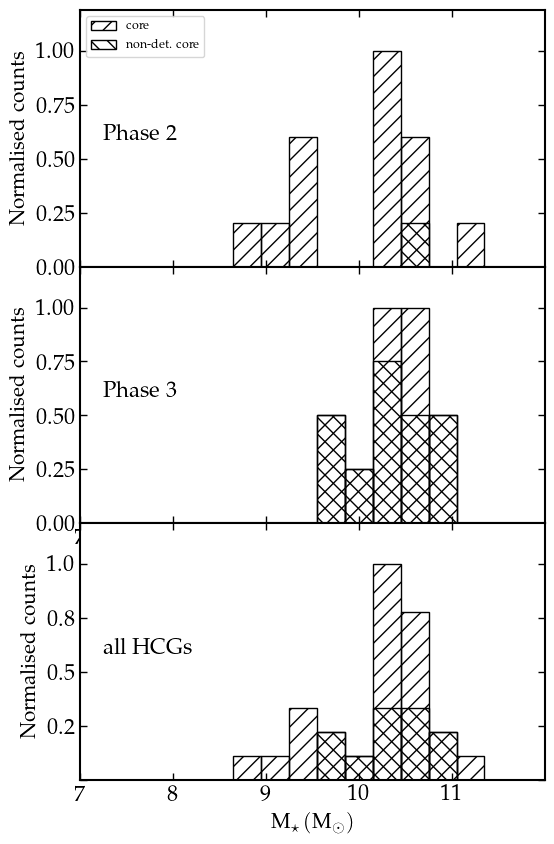

In [192]:
def hist_std(x, n_samples=1000):

       # Generate bootstrap samples and calculate the median for each sample
       bootstrap_medians = [
       x.sample(frac=1, replace=True).median() for _ in range(n_samples)
       ]
       # Calculate the standard deviation of the bootstrap medians, which is the error on the median
       median_error = np.std(bootstrap_medians)
       return median_error


def make_hist_axes(n, ax):
       if n in [2,3]:
              gp = {2: [16,31,91], 3: [30,90,97]}
              p = gp[n]
              df_cores_p = df_cores[df_cores.HCG.isin(p)]
              df_nocores_p = df_nocores[df_nocores.HCG.isin(p)]
       else:
              df_cores_p, df_nocores_p = df_cores, df_nocores
              
       mslims, step = [7,12], 0.3
       
       c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores_p, df_nocores_p, 'logMs', step, mslims)
       
       cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
              fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)
       ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
              hatch='\\\\', alpha=1, label='non-det. core', zorder=4);
       # obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       #        alpha=0.7, label='outskirts', zorder=1);
       # ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
       #        alpha=0.4, label='non-det. outskirts', zorder=4);
       ax.set_ylabel('Normalised counts', size=15);
       ax.set_xlim(7,12)
       if n == 2:
              ax.legend(loc='upper left', fontsize=9, frameon=True);
              shift, shift_val = [5], 0.07
              opaque = [6]
       elif n == 3:
              shift, shift_val = [], 0.01
              opaque = [8,9]
       else:
              ax.set_xlabel(r'$\rm M_\star\,(M_\odot)$', size=15)
              yticks = ax.get_yticks()
              ytick_labels = ["" if tick == 0 else '%.1f' %tick for tick in yticks]
              ax.set_yticklabels(ytick_labels)
              shift, shift_val = [], 0.01
              opaque=[5,6,8,9]

       # show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
       # show_bin_counts(obars, o_counts_num, color='#777977', shift=shift, shift_val=shift_val, opaque=opaque, ax=ax)
       
       if n in [2,3]:
              txt = f'Phase {n}'
       else:
              txt = 'all HCGs'
       ax.set_ylim(ymax=1.19)
       ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
       ax.text(0.05, 0.55, txt, ha='left', va='top', transform=ax.transAxes)
       ax.set_xticks(np.arange(7,12))
       
       print('Phase: %d\n   core: %.2f+/-%.2f, outskirts: %.2f+/-%.2f' 
             %(n,np.nanmedian(df_cores_p.logMs.values), hist_std(df_cores_p.logMs), np.nanmedian(df_nocores_p.logMs.values), hist_std(df_nocores_p.logMs)))
       ks_stat, p_val = ks_2samp(df_cores_p.logMs.values, df_nocores_p.logMs.values)
       print(f'ks = {ks_stat:.2f}, p = {p_val:.5f}')

fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(3,1, height_ratios=[1,1,1], hspace=0)
axt = fig.add_subplot(gs[0])
axm = fig.add_subplot(gs[1], sharex=axt)
axb = fig.add_subplot(gs[2], sharex=axt)

for n, ax in zip([2,3,0], [axt,axm,axb]):
       make_hist_axes(n, ax)
plt.setp(axt.get_xticklabels(), visible=False);
plt.savefig(figdir+'hist_mstar_phases_all.png')

## Appendix: ESO galaxies included in HCG 90's core

In [174]:
import importlib
import hidefutils
importlib.reload(hidefutils)
import hidefutils as utils

In [175]:
group_list = ['HCG 16', 'HCG 30', 'HCG 31', 'HCG 90', 'HCG 91', 'HCG 97']
for g in group_list:
    x, _ = utils.hcg_hi_content(g, plot=False, mem_file='group_members_app.yml', tabdir='app_params_tables/')
# x, _ = utils.hcg_hi_content('HCG 16', plot=False)

/mnt/scratch/HCGs/hidefutils.py:1725: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)
/mnt/scratch/HCGs/hidefutils.py:1726: RuntimeWarning: All-NaN slice encountered
  pb_median = np.nanmedian(np.squeeze(pb_data), axis=0)
/mnt/scratch/HCGs/hidefutils.py:1725: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)
/mnt/scratch/HCGs/hidefutils.py:1726: RuntimeWarning: All-NaN slice encountered
  pb_median = np.nanmedian(np.squeeze(pb_data), axis=0)
/opt/conda/envs/hidef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/opt/conda/envs/hidef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/opt/conda/envs/hidef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py

HCG 91 -- HCG 91D: no moment map found, assuming a non-detection


/mnt/scratch/HCGs/hidefutils.py:1725: RuntimeWarning: All-NaN slice encountered
  noise_median = np.nanmedian(noise_data, axis=0)
/mnt/scratch/HCGs/hidefutils.py:1726: RuntimeWarning: All-NaN slice encountered
  pb_median = np.nanmedian(np.squeeze(pb_data), axis=0)


### Plot relations of MHI and defHI

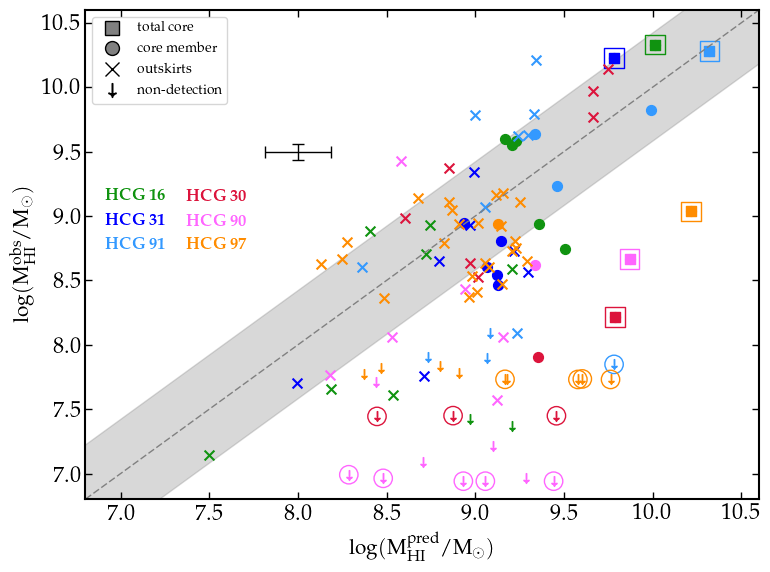

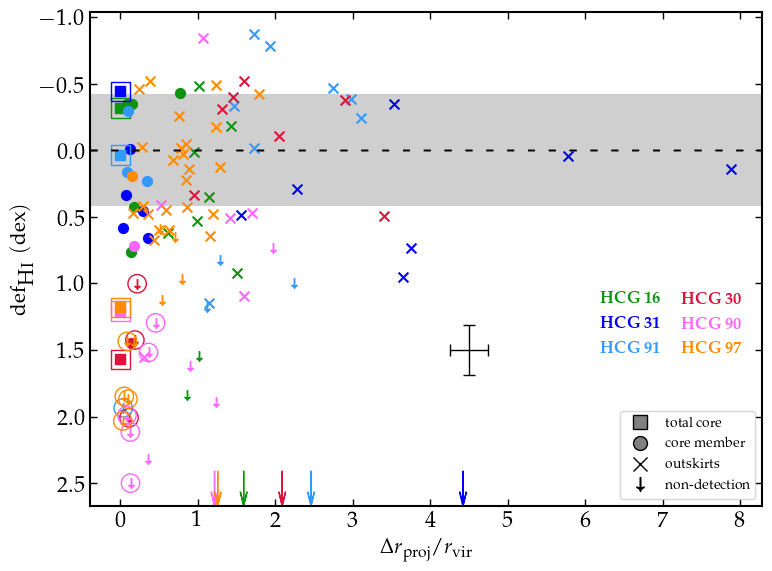

In [213]:
group_list = ['HCG 16', 'HCG 31', 'HCG 91', 'HCG 30', 'HCG 90', 'HCG 97']

### Plot MHI vs Ms
utils.plot_defhi(group_list, par='mass', tabdir='./app_params_tables/', figdir='./app_hidef_figures/', savefig=True)

### Plot HI-def vs dist
utils.plot_defhi(group_list, par='hidef', tabdir='./app_params_tables/', figdir='./app_hidef_figures/', savefig=True)

### Mstar distribution

In [197]:
figdir = '/mnt/scratch/HCGs/app_hidef_figures/'

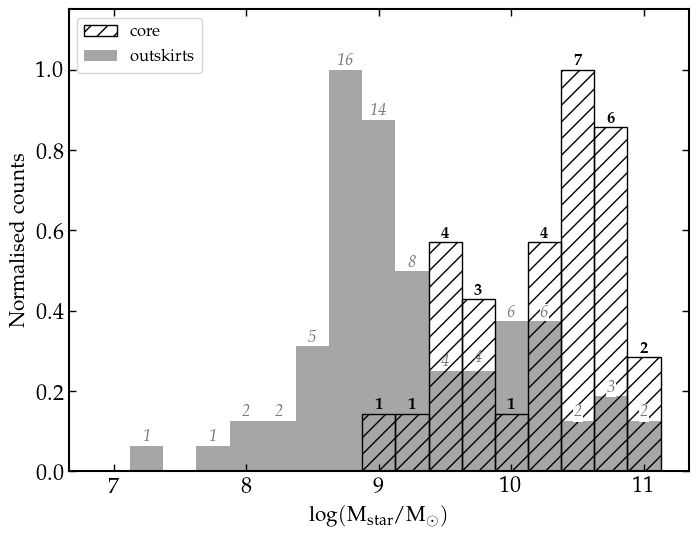

In [198]:
figdir = '/mnt/scratch/HCGs/app_hidef_figures/'

markers = {'HCG 16': ['o','#00CCCC'],
            'HCG 30': ['x','#DC143C'],
            'HCG 31': ['o','#0000FF'],
            'HCG 90': ['x','#FF66FF'],
            'HCG 91': ['o','#3399FF'],
            'HCG 97': ['x','#FF8C00']
            }

# Compute the histograms and normalize them
def make_hist(data:np.ndarray, lims:list=[7,11.5], step=0.25, norm=True):
    counts, bin_edges = np.histogram(data, bins=np.arange(lims[0],lims[1],step))
    if norm:
        counts = counts / counts.max()
    return counts, bin_edges

def show_bin_counts(bars, nums, color='k', size=12, bold=False, opaque=[], shift=[], shift_val=0.01, ax=None):
    if bold:
        wgt = r'\bf'
    else:
        wgt = r'\it'
    for i, (bar, num) in enumerate(zip(bars, nums)):
        if num > 0:
            if i in shift:
                yshift = shift_val
            else:
                yshift = 0.
            if i in opaque:
                bbox_props = dict(facecolor='w', edgecolor='None', alpha=1, pad=0.5)
            else:
                bbox_props = None
            txt = ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position of the label
                bar.get_height() + yshift,  # Y position of the label
                r'$%s{%s}$' %(wgt,num),
                color=color,
                size=size,
                ha='center', va='bottom',
                bbox = bbox_props,
                zorder=50)
        
df_cores, df_nocores = pd.DataFrame(), pd.DataFrame()
for hcgno in [16, 30, 31, 90, 91, 97]:
    marker = markers[f'HCG {hcgno}']
    df = pd.read_csv(f'/mnt/scratch/HCGs/app_params_tables/HIdef_hcg{hcgno}.csv')
    df.dropna(subset=['Name'], inplace=True)
    df = df[df.Name.str.replace(' ', '') != 'core:total']
    m_core = df.Name.str.contains('core')
    df_core, df_nocore = df[m_core], df[~m_core]
    df_cores = pd.concat([df_cores, df_core])
    df_nocores = pd.concat([df_nocores, df_nocore])

step = 0.25
c_counts, c_bin_edges = make_hist(df_cores.logMs.values, step=step)
o_counts, o_bin_edges = make_hist(df_nocores.logMs.values, step=step)

c_counts_num, _ = make_hist(df_cores.logMs.values, step=step, norm=False)
o_counts_num, _ = make_hist(df_nocores.logMs.values, step=step, norm=False)

fig, ax = plt.subplots(figsize=(8,6))
cbars = ax.bar(c_bin_edges[:-1], c_counts, width=c_bin_edges[1]-c_bin_edges[0], ec='k',
       fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)

obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       alpha=0.7, label='outskirts', zorder=1);

show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
show_bin_counts(obars, o_counts_num, color='#777977', shift=[11], opaque=[13,14,15,16], ax=ax)

ax.set_ylim(ymax=1.15)
ax.set_xlabel(r'$\rm \log(M_{star}/M_\odot)$', size=15)
ax.set_ylabel('Normalised counts', size=15);
ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
ax.legend(loc='upper left', fontsize=12, frameon=True);
plt.savefig(figdir+'hist_mstar.pdf')

### HI-def distribution

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


core: 0.76+/-0.03, outskirts: 0.41+/-0.01


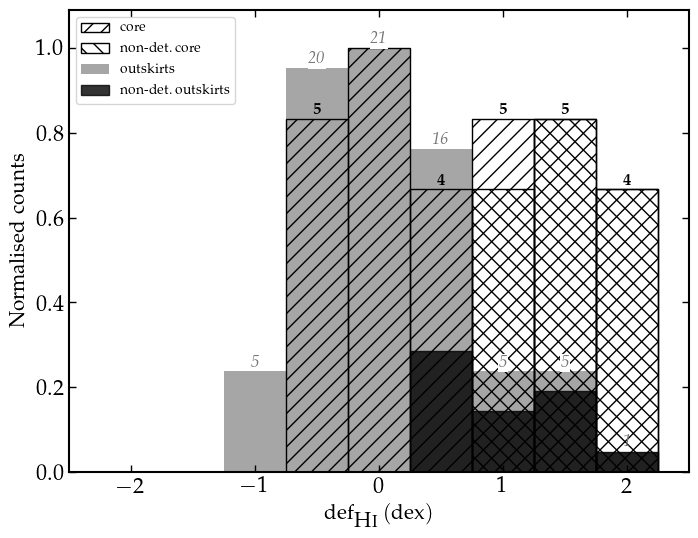

In [199]:
deflims, step = [-3,3], 0.5
c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores, df_nocores, 'defHI', step, deflims)

fig, ax = plt.subplots(figsize=(8,6))
cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
       fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)
ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
       hatch='\\\\', alpha=1, label='non-det. core', zorder=4);
obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
       alpha=0.7, label='outskirts', zorder=1);
ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
       alpha=0.8, label='non-det. outskirts', zorder=4);

show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
show_bin_counts(obars, o_counts_num, color='#777977', opaque=[5,6,8,9], ax=ax)

print('core: %.2f+/-%.2f, outskirts: %.2f+/-%.2f' 
       %(np.nanmedian(df_cores.defHI.values),np.nanstd(df_cores.defHI.values)/len(df_cores.defHI.values), np.nanmedian(df_nocores.defHI.values), np.nanstd(df_nocores.defHI.values)/len(df_nocores.defHI.values)))

ax.set_xlim(-2.5,2.5)
ax.set_ylim(ymax=1.09)
ax.set_xlabel(r'$\rm def_\textsc{Hi}\,(dex)$', size=15)
ax.set_ylabel('Normalised counts', size=15);
ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
ax.set_xticks(np.arange(-2,3))
ax.legend(loc='upper left', fontsize=10, frameon=True);
plt.savefig(figdir+'hist_hidef.pdf')

### HI-def distribution: comparison of core and outskirts and different phases

/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 2
   core: 0.28+/-0.19, outskirts: 0.29+/-0.22
ks = 0.37, p = 0.10074


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num


Phase: 3
   core: 1.52+/-0.22, outskirts: 0.42+/-0.12
ks = 0.69, p = 0.00001


/tmp/ipykernel_3387139/1339247358.py:16: RuntimeWarning: invalid value encountered in divide
  cl_counts_norm = c_counts * cl_counts_num/c_counts_num
/tmp/ipykernel_3387139/1339247358.py:17: RuntimeWarning: invalid value encountered in divide
  ol_counts_norm = o_counts * ol_counts_num/o_counts_num
/tmp/ipykernel_3387139/1480042893.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels)


Phase: 0
   core: 0.76+/-0.35, outskirts: 0.41+/-0.12
ks = 0.24, p = 0.12974


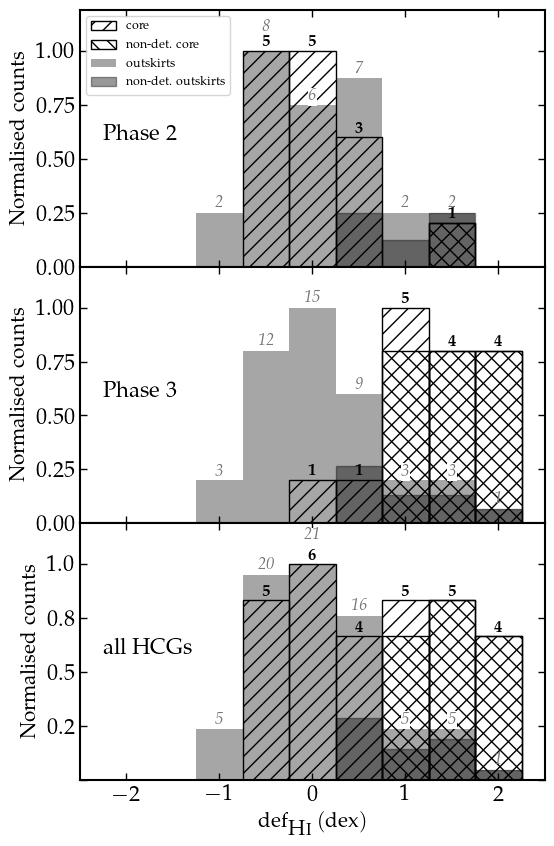

In [200]:
def hist_std(x, n_samples=1000):

       # Generate bootstrap samples and calculate the median for each sample
       bootstrap_medians = [
       x.sample(frac=1, replace=True).median() for _ in range(n_samples)
       ]
       # Calculate the standard deviation of the bootstrap medians, which is the error on the median
       median_error = np.std(bootstrap_medians)
       return median_error


def make_hist_axes(n, ax):
       if n in [2,3]:
              gp = {2: [16,31,91], 3: [30,90,97]}
              p = gp[n]
              df_cores_p = df_cores[df_cores.HCG.isin(p)]
              df_nocores_p = df_nocores[df_nocores.HCG.isin(p)]
       else:
              df_cores_p, df_nocores_p = df_cores, df_nocores
              
       deflims, step = [-3,3], 0.5
       
       c_counts, c_bin_edges, o_counts, o_bin_edges, cl_counts_norm, ol_counts_norm, c_counts_num, o_counts_num = return_counts(df_cores_p, df_nocores_p, 'defHI', step, deflims)
       
       cbars = ax.bar(c_bin_edges[:-1], c_counts, width=step, ec='k',
              fc='None', lw=1, alpha=1, hatch='//', label='core', zorder=2)
       ax.bar(c_bin_edges[:-1], cl_counts_norm, width=step, ec='k', fc='None',
              hatch='\\\\', alpha=1, label='non-det. core', zorder=4);
       obars = ax.bar(o_bin_edges[:-1], o_counts, width=step, color='gray',
              alpha=0.7, label='outskirts', zorder=1);
       ax.bar(o_bin_edges[:-1], ol_counts_norm, width=step, ec='k', fc='k',
              alpha=0.4, label='non-det. outskirts', zorder=4);
       ax.set_ylabel('Normalised counts', size=15);
       ax.set_xlim(-2.5,2.5)
       if n == 2:
              ax.legend(loc='upper left', fontsize=9, frameon=True);
              shift, shift_val = [5], 0.07
              opaque = [6]
       elif n == 3:
              shift, shift_val = [], 0.01
              opaque = [8,9]
       else:
              ax.set_xlabel(r'$\rm def_\textsc{Hi}\,(dex)$', size=15)
              yticks = ax.get_yticks()
              ytick_labels = ["" if tick == 0 else '%.1f' %tick for tick in yticks]
              ax.set_yticklabels(ytick_labels)
              shift, shift_val = [6], 0.09
              opaque=[5,6,8,9]

       show_bin_counts(cbars, c_counts_num, bold=True, ax=ax)
       show_bin_counts(obars, o_counts_num, color='#777977', shift=shift, shift_val=shift_val, opaque=opaque, ax=ax)
       
       if n in [2,3]:
              txt = f'Phase {n}'
       else:
              txt = 'all HCGs'
       ax.set_ylim(ymax=1.19)
       ax.tick_params(axis='both', direction='in', right=True, top=True, length=5, width=1)
       ax.text(0.05, 0.55, txt, ha='left', va='top', transform=ax.transAxes)
       ax.set_xticks(np.arange(-2,3))
       
       print('Phase: %d\n   core: %.2f+/-%.2f, outskirts: %.2f+/-%.2f' 
             %(n,np.nanmedian(df_cores_p.defHI.values), hist_std(df_cores_p.defHI), np.nanmedian(df_nocores_p.defHI.values), hist_std(df_nocores_p.defHI)))
       ks_stat, p_val = ks_2samp(df_cores_p.defHI.values, df_nocores_p.defHI.values)
       print(f'ks = {ks_stat:.2f}, p = {p_val:.5f}')

fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(3,1, height_ratios=[1,1,1], hspace=0)
axt = fig.add_subplot(gs[0])
axm = fig.add_subplot(gs[1], sharex=axt)
axb = fig.add_subplot(gs[2], sharex=axt)

for n, ax in zip([2,3,0], [axt,axm,axb]):
       make_hist_axes(n, ax)
plt.setp(axt.get_xticklabels(), visible=False);
plt.savefig(figdir+'hist_hidef_phases_all.pdf')